# 这一版 在他们的基础上，加上自己特征工程上的处理

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import os

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import json 
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from itertools import product
import ast
import math
from sklearn.cluster import KMeans
import time
from datetime import datetime

In [2]:
data=pd.read_csv('./new_feature_data/shanghai_2019-06-09_20_57_all_features.csv',parse_dates=['req_time'])

In [4]:
data.columns.values

array(['click_mode', 'click_time', 'd', 'o', 'pid', 'plan_time', 'plans',
       'req_time', 'sid', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7',
       'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17',
       'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26',
       'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35',
       'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44',
       'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53',
       'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62',
       'p63', 'p64', 'p65', 'o_lng', 'o_lat', 'd_lng', 'd_lat',
       'od_manhattan_distance', 'od_manhattan_distance_detail',
       'o_main_centroid_mean_dis', 'd_main_centroid_mean_dis',
       'o_main_centroid_mode_dis', 'd_main_centroid_mode_dis',
       "('o_cluster', 'd_cluster')", 'o_cluster', 'd_cluster',
       'manhattan', 'euclidean', 'delta_longitude', 'delta_latitude',
       'pickup_x', 'pickup_y', 'pickup_z

In [4]:
data.o

0         121.51,31.23
1         121.32,31.30
2         121.45,31.25
3         121.28,31.35
4         121.24,31.40
5         121.45,31.20
6         121.45,31.25
7         121.48,31.24
8         121.52,31.23
9         121.23,31.02
10        121.52,31.23
11        121.45,31.25
12        121.48,31.30
13        121.37,31.27
14        121.23,31.06
15        121.40,31.26
16        121.64,31.34
17        121.50,31.30
18        121.45,31.19
19        121.49,31.24
20        121.49,31.21
21        121.60,31.14
22        121.54,31.21
23        121.42,31.16
24        121.51,31.17
25        121.47,31.24
26        121.49,31.23
27        121.46,31.21
28        121.43,31.17
29        121.55,31.21
              ...     
585903    121.42,31.20
585904    121.25,31.41
585905    121.57,31.12
585906    121.31,31.27
585907    121.49,31.14
585908    121.48,31.23
585909    121.47,31.40
585910    121.31,31.19
585911    121.40,31.13
585912    121.47,31.27
585913    121.47,31.21
585914    121.44,31.23
585915    1

## 数据处理（不均衡问题  ）

#### 在训练集上做过采样（不可用，舍弃，直接内存就爆了）

In [110]:
# from imblearn.over_sampling import SMOTE       #过度抽样处理库SMOTE
# from imblearn.under_sampling import RandomUnderSampler
# #进行两种采样方式的处理，欠采样和过采样的处理，尝试在重要的10个特征上面进行采样，来获得标签
# #过采样处理\



# train_x     = data[train_index][feature].reset_index(drop=True)
# train_y     = data[train_index].click_mode.reset_index(drop=True)


# train_x.replace(-np.inf,-1,inplace=True)
# train_x.fillna(-99,inplace=True)
# #groupby_data_orginal = y.groupby('label').count()
# #print(x)
# #print(y)
# model_smote = SMOTE()  # 建立smote模型对象
# x_smote_resampled, y_smote_resampled = model_smote.fit_sample(train_x, train_y)
# x_smote_resampled = pd.DataFrame(x_smote_resampled, columns=feature)
# y_smote_resampled = pd.DataFrame(y_smote_resampled, columns=['y'])
# smote_resampled = pd.concat([x_smote_resampled, y_smote_resampled], axis=1)
# groupby_data_smote = smote_resampled.groupby('y').count()
# smote_resampled.to_csv('./经过过采样后的数据.csv')
# print(smote_resampled)

MemoryError: 

In [105]:

print(np.isnan(data[train_index][feature]).any())

o_lng                                False
o_lat                                False
d_lng                                False
d_lat                                False
p0                                    True
p1                                    True
p2                                    True
p3                                    True
p4                                    True
p5                                    True
p6                                    True
p7                                    True
p8                                    True
p9                                    True
p10                                   True
p11                                   True
p12                                   True
p13                                   True
p14                                   True
p15                                   True
p16                                   True
p17                                   True
p18                                   True
p19        

In [107]:
print(np.isnan(data[train_index].click_mode).any())

False


In [108]:

print(np.isfinite(data[train_index][feature]).all())

o_lng                                 True
o_lat                                 True
d_lng                                 True
d_lat                                 True
p0                                   False
p1                                   False
p2                                   False
p3                                   False
p4                                   False
p5                                   False
p6                                   False
p7                                   False
p8                                   False
p9                                   False
p10                                  False
p11                                  False
p12                                  False
p13                                  False
p14                                  False
p15                                  False
p16                                  False
p17                                  False
p18                                  False
p19        

### 降采样

# 特征工程

### 协同特征的改造

In [11]:
# #第一轮组合扩展，  有效
# data['sloc_eloc_common_eloc_rate_1'] = data['sloc_eloc_common_eloc_count']/(data['sloc_as_eloc_count']+data['eloc_count'])
# data['sloc_eloc_common_sloc_rate_1'] = data['sloc_eloc_common_sloc_count']/(data['sloc_count']+data['eloc_as_sloc_count'])
# data['sloc_eloc_common_conn1_rate_1'] = data['sloc_eloc_common_conn1_count']/(data['sloc_as_eloc_count']+data['eloc_as_sloc_count'])
# data['sloc_eloc_common_conn2_rate_1'] = data['sloc_eloc_common_conn2_count']/(data['sloc_count']+data['eloc_count'])
# data['user_sloc_eloc_common_eloc_rate_1'] = data['user_sloc_eloc_common_eloc_count']/(data['user_sloc_as_eloc_count']+data['user_eloc_count'])
# data['user_sloc_eloc_common_sloc_rate_1'] = data['user_sloc_eloc_common_sloc_count']/(data['user_sloc_count']+data['user_eloc_as_sloc_count'])
# data['user_sloc_eloc_common_conn1_rate_1'] = data['user_sloc_eloc_common_conn1_count']/(data['user_sloc_as_eloc_count']+data['user_eloc_as_sloc_count'])
# data['user_sloc_eloc_common_conn2_rate_1'] = data['user_sloc_eloc_common_conn2_count']/(data['user_sloc_count']+data['user_eloc_count'])


## 泛化转化率特征


####  对距离进行分箱后的转换率统计

In [21]:
data.columns.values

array(['click_mode', 'click_time', 'd', 'o', 'pid', 'plan_time', 'plans',
       'req_time', 'sid', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7',
       'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17',
       'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26',
       'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35',
       'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44',
       'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53',
       'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62',
       'p63', 'p64', 'p65', 'o_lng', 'o_lat', 'd_lng', 'd_lat',
       'od_manhattan_distance', 'od_manhattan_distance_detail',
       'o_main_centroid_mean_dis', 'd_main_centroid_mean_dis',
       'o_main_centroid_mode_dis', 'd_main_centroid_mode_dis',
       "('o_cluster', 'd_cluster')", 'o_cluster', 'd_cluster',
       'manhattan', 'euclidean', 'delta_longitude', 'delta_latitude',
       'pickup_x', 'pickup_y', 'pickup_z

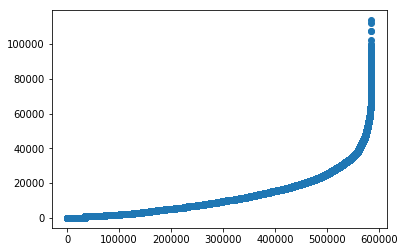

In [23]:
plt.scatter(range(len(data['od_manhattan_distance_detail'])),data['od_manhattan_distance_detail'].sort_values().values)


In [28]:
np.max(data['od_manhattan_distance_detail'])
data['od_manhattan_distance_detail']

0          1464.647462
1          9683.623163
2          2226.389816
3         22318.841470
4           950.168401
5          1904.374275
6          9191.916713
7         15869.281090
8          2855.655193
9          3070.714170
10          951.885067
11        35136.557840
12         6515.780149
13            0.000000
14        27506.637602
15        22143.159148
16        18213.294002
17         1113.194908
18         7027.315718
19         1113.194908
20        30297.255908
21            0.000000
22        11904.860212
23        36270.597768
24         3622.182207
25         2205.083399
26         1464.647462
27         5064.752936
28         8021.670607
29        19335.335038
              ...     
585903     2856.561408
585904    25516.855758
585905    18353.554872
585906    23215.657125
585907    10198.197136
585908        0.000000
585909    18948.194938
585910     5860.290798
585911        0.000000
585912     1113.194908
585913     4842.683848
585914     3621.229602
585915     

In [30]:
data['od_manhattan_distance']

0         0.02
1         0.12
2         0.02
3         0.27
4         0.01
5         0.02
6         0.12
7         0.20
8         0.03
9         0.04
10        0.01
11        0.45
12        0.09
13        0.00
14        0.38
15        0.26
16        0.20
17        0.01
18        0.09
19        0.01
20        0.31
21        0.00
22        0.15
23        0.40
24        0.05
25        0.03
26        0.02
27        0.07
28        0.09
29        0.23
          ... 
585903    0.03
585904    0.35
585905    0.23
585906    0.31
585907    0.11
585908    0.00
585909    0.18
585910    0.08
585911    0.00
585912    0.01
585913    0.06
585914    0.05
585915    0.01
585916    0.04
585917    0.12
585918    0.04
585919    0.04
585920    0.03
585921    0.13
585922    0.00
585923    0.13
585924    0.02
585925    0.67
585926    0.06
585927    0.02
585928    0.00
585929    0.18
585930    0.09
585931    0.01
585932    0.17
Name: od_manhattan_distance, Length: 585933, dtype: float64

In [29]:
#对距离做分箱   分12个箱子    对起点进行分箱

bins = [0,5000,10000,15000,20000,40000,120000]

res1 = pd.cut(data['od_manhattan_distance_label'], bins, labels=["u","i","m","n","v",'p'])


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(res1)
data['od_manhattan_distance_label']=le.transform(res1)
data['od_manhattan_distance_label']

0          a
1          f
2          b
3          u
4          a
5          a
6          f
7          y
8          b
9          b
10         a
11         i
12         c
13        gg
14         u
15         u
16         y
17         a
18         c
19         a
20         i
21        gg
22         r
23         i
24         b
25         b
26         a
27         c
28         f
29         y
          ..
585903     b
585904     u
585905     y
585906     u
585907     r
585908    gg
585909     y
585910     c
585911    gg
585912     a
585913     b
585914     b
585915     a
585916     b
585917     r
585918     b
585919     b
585920     b
585921     f
585922    gg
585923     r
585924     a
585925     m
585926     b
585927     a
585928    gg
585929     t
585930     f
585931     a
585932     y
Name: od_manhattan_distance_detail, Length: 585933, dtype: category
Categories (14, object): [gg < a < b < c ... m < n < v < p]


0          0
1          3
2          1
3         11
4          0
5          0
6          3
7         13
8          1
9          1
10         0
11         5
12         2
13         4
14        11
15        11
16        13
17         0
18         2
19         0
20         5
21         4
22         9
23         5
24         1
25         1
26         0
27         2
28         3
29        13
          ..
585903     1
585904    11
585905    13
585906    11
585907     9
585908     4
585909    13
585910     2
585911     4
585912     0
585913     1
585914     1
585915     0
585916     1
585917     9
585918     1
585919     1
585920     1
585921     3
585922     4
585923     9
585924     0
585925     6
585926     1
585927     0
585928     4
585929    10
585930     3
585931     0
585932    13
Name: od_manhattan_distance_label, Length: 585933, dtype: int32

In [6]:

#三种根据label的统计方式
def add_statistics_o_conut_label(data, feat='od_manhattan_distance_label'):
    print('adding statistics ...')

    # stat_data = data
    # not contain val set
    train_index = (data.req_time < '2018-11-23')
    stat_data = data[train_index][['click_mode', feat]].reset_index(drop=True)

    # static features
    # each click mode for each feat, the number and the probability
    feat_stat = stat_data[['click_mode', feat]]
    feat_stat['feat_click_count'] = 1
    # the number         可以看到有加了一列特征为1，这里是对那个1进行过计数的
    feat_stat = feat_stat.groupby(['click_mode', feat]).agg('sum').reset_index()
    #print(feat_stat)
    feat_stat = feat_stat.sort_index(by=[feat, 'click_mode']).reset_index()

    feat_sum = stat_data[[feat]]
    feat_sum['feat_sum'] = 1
    feat_sum = feat_sum.groupby([feat]).agg('sum').reset_index()
    feat_sum = feat_sum.sort_index(by=[feat]).reset_index()
    feat_mode_arr = np.zeros((len(feat_sum['feat_sum']), 12), dtype=np.float)

    # print(feat_sum)
    # print(feat_stat[feat])
    # print(feat_mode_arr[:, -1])
    idx = 0
    for r_i, row in feat_stat.iterrows():
        # print(row)
        if int(row[feat]) != feat_sum[feat].values[idx]:
            # print('%d, %d, %d, %d' % (r_i, idx, int(row[feat]), feat_sum[feat].values[idx]))
            # if idx > 100:
            #     break
            idx += 1
        # the probability
        feat_mode_arr[idx, int(row['click_mode'])] = row['feat_click_count'] / feat_sum['feat_sum'].values[idx]

    feat_mode = {}
    feat_mode[feat] = feat_sum[feat]
    for i in range(12):
        feat_mode[feat + '_mode_' + str(i)] = feat_mode_arr[:, i]
    feat_mode = pd.DataFrame(feat_mode)
    data = data.merge(feat_mode, on=feat, how='left')

    return data

#add_statistics_o_conut_label(data, 'od_manhattan_distance_label')

0          0
1          3
2          1
3         11
4          0
5          0
6          3
7         13
8          1
9          1
10         0
11         5
12         2
13         4
14        11
15        11
16        13
17         0
18         2
19         0
20         5
21         4
22         9
23         5
24         1
25         1
26         0
27         2
28         3
29        13
          ..
585903     1
585904    11
585905    13
585906    11
585907     9
585908     4
585909    13
585910     2
585911     4
585912     0
585913     1
585914     1
585915     0
585916     1
585917     9
585918     1
585919     1
585920     1
585921     3
585922     4
585923     9
585924     0
585925     6
585926     1
585927     0
585928     4
585929    10
585930     3
585931     0
585932    13
Name: od_manhattan_distance_label, Length: 585933, dtype: int32

#### std_eta的转化率挖掘

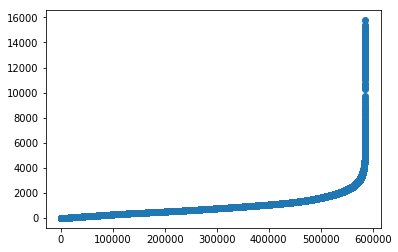

In [44]:
plt.scatter(range(len(data['std_eta'])),data['std_eta'].sort_values().values)

In [7]:
#对距离做分箱   分12个箱子    对起点进行分箱

bins = [-10,0,200,500,800,1100,1500,2000,4000,16000]

res1 = pd.cut(data['std_eta'], bins, labels=['gg',"a","b","c","f","r","t","y","u"])

print(res1)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(res1)
data['std_eta_label']=le.transform(res1)


data=add_statistics_o_conut_label(data, 'std_eta_label')

0          b
1          a
2         gg
3          y
4          b
5          f
6          c
7          c
8          f
9          f
10         c
11         r
12         f
13         b
14         f
15         y
16         y
17         b
18         b
19         c
20         y
21         a
22         c
23         r
24         f
25         c
26         b
27         b
28         c
29         t
          ..
585903     c
585904     b
585905     t
585906    gg
585907     b
585908     a
585909     c
585910     c
585911     a
585912     b
585913     r
585914     r
585915     b
585916     r
585917     b
585918     r
585919     f
585920     b
585921     a
585922     a
585923     f
585924     c
585925     y
585926     r
585927     b
585928     b
585929     y
585930     f
585931     a
585932     c
Name: std_eta, Length: 585933, dtype: category
Categories (9, object): [gg < a < b < c ... r < t < y < u]
adding statistics ...


#### std_dist的转化率挖掘（有些提升，现在放大区分性）

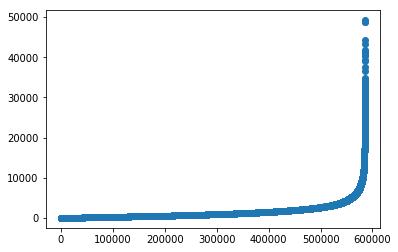

In [45]:
plt.scatter(range(len(data['std_dist'])),data['std_dist'].sort_values().values)

In [86]:
np.max(data['std_dist'])

49228.30270168666

In [8]:
#对距离做分箱   分12个箱子    对起点进行分箱
#三种根据label的统计方式
def add_statistics_o_conut_label(data, feat='od_manhattan_distance_label'):
    print('adding statistics ...')

    # stat_data = data
    # not contain val set
    train_index = (data.req_time < '2018-11-23')
    stat_data = data[train_index][['click_mode', feat]].reset_index(drop=True)

    # static features
    # each click mode for each feat, the number and the probability
    feat_stat = stat_data[['click_mode', feat]]
    feat_stat['feat_click_count'] = 1
    # the number         可以看到有加了一列特征为1，这里是对那个1进行过计数的
    feat_stat = feat_stat.groupby(['click_mode', feat]).agg('sum').reset_index()
    #print(feat_stat)
    feat_stat = feat_stat.sort_index(by=[feat, 'click_mode']).reset_index()

    feat_sum = stat_data[[feat]]
    feat_sum['feat_sum'] = 1
    feat_sum = feat_sum.groupby([feat]).agg('sum').reset_index()
    feat_sum = feat_sum.sort_index(by=[feat]).reset_index()
    feat_mode_arr = np.zeros((len(feat_sum['feat_sum']), 12), dtype=np.float)

    # print(feat_sum)
    # print(feat_stat[feat])
    # print(feat_mode_arr[:, -1])
    idx = 0
    for r_i, row in feat_stat.iterrows():
        # print(row)
        if int(row[feat]) != feat_sum[feat].values[idx]:
            # print('%d, %d, %d, %d' % (r_i, idx, int(row[feat]), feat_sum[feat].values[idx]))
            # if idx > 100:
            #     break
            idx += 1
        # the probability
        feat_mode_arr[idx, int(row['click_mode'])] = row['feat_click_count'] / feat_sum['feat_sum'].values[idx]

    feat_mode = {}
    feat_mode[feat] = feat_sum[feat]
    for i in range(12):
        feat_mode[feat + '_mode_' + str(i)] = feat_mode_arr[:, i]
    feat_mode = pd.DataFrame(feat_mode)
    data = data.merge(feat_mode, on=feat, how='left')

    return data



bins = [-10,1000,2000,3000,4000,6000,8000,50000]

res1 = pd.cut(data['std_dist'], bins, labels=["u",'eee','ddd','sss','aaa','QQQ','CCC'])

print(res1)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(res1)
data['std_dist_label']=le.transform(res1)


data=add_statistics_o_conut_label(data, 'std_dist_label')

0           u
1           u
2           u
3         CCC
4           u
5           u
6         ddd
7         eee
8           u
9           u
10          u
11        ddd
12        ddd
13          u
14        eee
15        eee
16        QQQ
17        eee
18        eee
19        eee
20        aaa
21          u
22          u
23        aaa
24          u
25          u
26          u
27          u
28          u
29        eee
         ... 
585903      u
585904    eee
585905    sss
585906      u
585907      u
585908      u
585909      u
585910      u
585911      u
585912      u
585913      u
585914      u
585915      u
585916      u
585917      u
585918      u
585919      u
585920      u
585921      u
585922      u
585923    eee
585924      u
585925    sss
585926    eee
585927      u
585928      u
585929    CCC
585930      u
585931      u
585932    eee
Name: std_dist, Length: 585933, dtype: category
Categories (7, object): [u < eee < ddd < sss < aaa < QQQ < CCC]
adding statistics ...


## 在plans平展中做较为深的挖掘（加上协同，更为深的区分度）

#### 进行相关性的观察，来察觉重要度高的特征，一般区分度较大的特征，往往更为重要。（有一定线性规律的）



      在plan中，新添加一些特征，表示协同的区分：
          *加入每个mode出现次数的计数
          
          *加上每个mode的 eta/dist、price之和、平均rank、  mode下的eta在整行的排序，dist在整列的排序， 平均price在整行的排序。
          *mode下的dist值和实际距离的差值，   dist值和平均dist的差值、和最小dist的差距、和最大dist的差距。   平均price和最大最小price的差距、平均eta和最大最小eta的差距。
          *price和平均price的差值       eta和平均eta的差距值、     在自己的mode下的最大最小eta、 最大最小dist、最大最小price
          *获取 整行下扩展统计的 price、distance等的median中位数，sum总和、协方差cov、nunique数量、feat_kernelMedian（植物大佬写的）、quantile(n)百分数。
          *第二个推荐mode是什么、第三个推荐 mode是什么。
          
      
      后建造：
          *每个price、eta在整列的排序，
          *每个pid下  dist综合、平均值，

第一波挖掘：
       
       *第二个推荐mode是什么、第三个推荐 mode是什么、第四个推荐 mode是什么、第五个推荐 mode是什么
       *dist  price  eta 的median、sum、var、quantile_4值

In [54]:
from scipy.stats import mode
data['plans_json'] = data['plans'].fillna('[]').apply(lambda x: json.loads(x))
def gen_plan_feas(data):
    n                                           = data.shape[0]
    mode_list_feas                              = np.zeros((n, 12))
    max_dist, min_dist, mean_dist, std_dist     = np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))

    max_price, min_price, mean_price, std_price = np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))

    max_eta, min_eta, mean_eta, std_eta         = np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))

    min_dist_mode, max_dist_mode, min_price_mode, max_price_mode, min_eta_mode, max_eta_mode, first_mode =     np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    #额外加的
    second_mode,third_mode,four_mode,five_mode        = np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    median_dist,sum_dist,var_dist,quantile_4_dist        = np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    median_price,sum_price,var_price,quantile_4_price  = np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    median_eta,sum_eta,var_eta,quantile_4_eta        = np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    mode_zhongshu      = np.zeros((n,))
    mode_texts = []
    for i, plan in tqdm(enumerate(data['plans_json'].values)):
        if len(plan) == 0:
            cur_plan_list   = []
        else:
            cur_plan_list   = plan
        if len(cur_plan_list) == 0:
            mode_list_feas[i, 0] =  1
            first_mode[i]        =  0
            max_dist[i]          = -1
            min_dist[i]          = -1
            mean_dist[i]         = -1
            std_dist[i]          = -1
            max_price[i]         = -1
            min_price[i]         = -1
            mean_price[i]        = -1
            std_price[i]         = -1
            max_eta[i]           = -1
            min_eta[i]           = -1
            mean_eta[i]          = -1
            std_eta[i]           = -1
            min_dist_mode[i]     = -1
            max_dist_mode[i]     = -1
            min_price_mode[i]    = -1
            max_price_mode[i]    = -1
            min_eta_mode[i]      = -1
            max_eta_mode[i]      = -1
            #自己新加的，整行上的统计
            second_mode[i]      =  -1 
            third_mode[i]        =  -1 
            four_mode[i]         =  -1 
            five_mode[i]         =  -1 
            mode_zhongshu        =  -1 
            
            median_dist[i]          =-1
            sum_dist[i]             =-1
            var_dist[i]             =-1
            quantile_4_dist[i]          =-1
            
            median_price[i]          =-1
            sum_price[i]             =-1
            var_price[i]             =-1
            quantile_4_price[i]          =-1

            median_eta[i]          =-1
            sum_eta[i]             =-1
            var_eta[i]             =-1
            quantile_4_eta[i]          =-1


            
            mode_texts.append('word_null')
        else:
            distance_list = []
            price_list = []
            eta_list = []
            mode_list = []
            for tmp_dit in cur_plan_list:
                distance_list.append(int(tmp_dit['distance']))
                if tmp_dit['price'] == '':
                    price_list.append(0)
                else:
                    price_list.append(int(tmp_dit['price']))
                eta_list.append(int(tmp_dit['eta']))
                mode_list.append(int(tmp_dit['transport_mode']))

            first_mode[i]                = mode_list[0]
            if len(mode_list)>1:
                second_mode[i]                = mode_list[1]
            else:
                second_mode[i]                = -1
            if len(mode_list)>2:
                third_mode[i]                = mode_list[2]
            else:
                third_mode[i]                = -1
            if len(mode_list)>3:
                four_mode[i]                = mode_list[3]
            else:
                four_mode[i]                = -1
            if len(mode_list)>4:
                five_mode[i]                = mode_list[4]
            else:
                five_mode[i]                = -1
                        
            median_dist[i]                = np.median(distance_list)
            sum_dist[i]                = np.sum(price_list)
            var_dist[i]                = np.var(eta_list)
            quantile_4_dist[i]                = np.quantile(eta_list,0.5)            
            median_price[i]                = np.median(distance_list)
            sum_price[i]                = np.sum(price_list)
            var_price[i]                = np.var(eta_list)
            quantile_4_price[i]                = np.quantile(eta_list,0.5)  
            median_eta[i]                = np.median(distance_list)
            sum_eta[i]                = np.sum(price_list)
            var_eta[i]                = np.var(eta_list)
            quantile_4_eta[i]                = np.quantile(eta_list,0.5)  
    feature_data                   =  pd.DataFrame(mode_list_feas)
#     feature_data.columns           =  ['mode_feas_{}'.format(i) for i in range(12)]
    feature_data['second_mode']       =  second_mode    
    feature_data['third_mode']       =  third_mode  
    feature_data['four_mode']       =  four_mode  
    feature_data['five_mode']       =  five_mode       
    
    feature_data['median_dist']       =  median_dist      
    feature_data['sum_dist']       =  sum_dist   
    feature_data['var_dist']       =  var_dist      
    feature_data['quantile_4_dist']       =  quantile_4_dist 
    
    feature_data['median_price']       =  median_price      
    feature_data['sum_price']       =  sum_price   
    feature_data['var_price']       =  var_price      
    feature_data['quantile_4_price']       =  quantile_4_price 
    
    feature_data['median_eta']       =  median_eta      
    feature_data['sum_eta']       =  sum_eta   
    feature_data['var_eta']       =  var_eta      
    feature_data['quantile_4_eta']       =  quantile_4_eta 
    feature_data['quantile_4_eta']       =  quantile_4_eta     

    feature_data['sid'] = data['sid'].values
    
    return feature_data

data_plans = gen_plan_feas(data)
data = data.merge(data_plans, on='sid', how='left')

585933it [05:21, 1824.11it/s]


第二波挖掘：
    
     *加入每个mode出现次数的计数
     *加上每个mode的 eta/dist、mode下的eta在整行的排序，dist在整列的排序， 平均price在整行的排序。
     *mode下的dist值和实际距离的差值，   dist值和平均dist的差值、和最小dist的差距、和最大dist的差距。   平均price和最大最小price的差距、平均eta和最大最小eta的差距。  
     *price和平均price的差值       eta和平均eta的差距值、     在自己的mode下的最大最小eta、 最大最小dist、最大最小price
     *加上每个mode的 eta/dist、price之和、平均rank、  mode下的eta在整行的排序，dist在整列的排序， 平均price在整行的排序。

          

     

In [79]:
#data['plans_json'] = data['plans'].fillna('[]').apply(lambda x: json.loads(x))
def gen_plan_pingpu_feas(data):  
    #创建用于放置mode平均距离、平均价格、平均eta、出现位置排名,共11个模式的11*4个特征 （为0的模式就不做标识了） 添加model所属的工具模态
    n                                           = data.shape[0]
    #mode_list_feas                              = np.zeros((n, 12))
    model_1_dist,model_1_price,model_1_eta,model_1_rank  =   np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    model_2_dist,model_2_price,model_2_eta,model_2_rank  =   np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    model_3_dist,model_3_price,model_3_eta,model_3_rank  =   np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    model_4_dist,model_4_price,model_4_eta,model_4_rank  =   np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    model_5_dist,model_5_price,model_5_eta,model_5_rank  =   np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    model_6_dist,model_6_price,model_6_eta,model_6_rank  =   np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    model_7_dist,model_7_price,model_7_eta,model_7_rank  =   np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    model_8_dist,model_8_price,model_8_eta,model_8_rank  =   np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    model_9_dist,model_9_price,model_9_eta,model_9_rank  =   np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    model_10_dist,model_10_price,model_10_eta,model_10_rank  =   np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    model_11_dist,model_11_price,model_11_eta,model_11_rank  =   np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    
    #新添加的   每个mode的计数   平均距离和实际距离的差值、距离和整体平均距离的差距
    model_1_count,model_2_count,model_3_count,model_4_count,model_5_count,model_6_count,model_7_count,model_8_count,model_9_count,model_10_count,model_11_count=np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,)),np.zeros((n,)), np.zeros((n,)), np.zeros((n,)), np.zeros((n,)),np.zeros((n,)), np.zeros((n,)), np.zeros((n,))
    #model_1_dist_max,model_1_dist_min,model_1_price
    
    
    n=0
    for i, plan in tqdm(enumerate(data['plans_json'].values)):
        if len(plan) == 0:
            cur_plan_list   = []
        else:
            cur_plan_list   = plan
        if len(cur_plan_list) == 0:
            
            model_1_count[i]=-1
            model_2_count[i]=-1
            model_3_count[i]=-1
            model_4_count[i]=-1
            model_5_count[i]=-1
            model_6_count[i]=-1
            model_7_count[i]=-1
            model_8_count[i]=-1
            model_9_count[i]=-1
            model_10_count[i]=-1
            model_11_count[i]=-1
        else:
            model_1_dist_list=[]
            model_1_price_list=[]
            model_1_eta_list=[]
            model_1_rank_list=[]
            model_2_dist_list=[]
            model_2_price_list=[]
            model_2_eta_list=[]
            model_2_rank_list=[]
            model_3_dist_list=[]
            model_3_price_list=[]
            model_3_eta_list=[]
            model_3_rank_list=[]
            model_4_dist_list=[]
            model_4_price_list=[]
            model_4_eta_list=[]
            model_4_rank_list=[]
            model_5_dist_list=[]
            model_5_price_list=[]
            model_5_eta_list=[]
            model_5_rank_list=[]
            model_6_dist_list=[]
            model_6_price_list=[]
            model_6_eta_list=[]
            model_6_rank_list=[]
            model_7_dist_list=[]
            model_7_price_list=[]
            model_7_eta_list=[]
            model_7_rank_list=[]
            model_8_dist_list=[]
            model_8_price_list=[]
            model_8_eta_list=[]
            model_8_rank_list=[]
            model_9_dist_list=[]
            model_9_price_list=[]
            model_9_eta_list=[]
            model_9_rank_list=[]
            model_10_dist_list=[]
            model_10_price_list=[]
            model_10_eta_list=[]
            model_10_rank_list=[]
            model_11_dist_list=[]
            model_11_price_list=[]
            model_11_eta_list=[]
            model_11_rank_list=[]


            model_list = []
            for tmp_dit in cur_plan_list:
                if tmp_dit['price'] == '':
                    tmp_dit['price']=0
                if tmp_dit['transport_mode']==1:
                    model_1_dist_list.append(int(tmp_dit['distance']))
                    model_1_price_list.append(int(tmp_dit['price']))
                    model_1_eta_list.append(int(tmp_dit['eta']))
                    
                elif tmp_dit['transport_mode']==2:
                    model_2_dist_list.append(int(tmp_dit['distance']))
                    model_2_price_list.append(int(tmp_dit['price']))
                    model_2_eta_list.append(int(tmp_dit['eta']))
                elif tmp_dit['transport_mode']==3:
                    model_3_dist_list.append(int(tmp_dit['distance']))
                    model_3_price_list.append(int(tmp_dit['price']))
                    model_3_eta_list.append(int(tmp_dit['eta']))
                elif tmp_dit['transport_mode']==4:
                    model_4_dist_list.append(int(tmp_dit['distance']))
                    model_4_price_list.append(int(tmp_dit['price']))
                    model_4_eta_list.append(int(tmp_dit['eta']))
                elif tmp_dit['transport_mode']==5:
                    model_5_dist_list.append(int(tmp_dit['distance']))
                    model_5_price_list.append(int(tmp_dit['price']))
                    model_5_eta_list.append(int(tmp_dit['eta']))
                elif tmp_dit['transport_mode']==6:
                    model_6_dist_list.append(int(tmp_dit['distance']))
                    model_6_price_list.append(int(tmp_dit['price']))
                    model_6_eta_list.append(int(tmp_dit['eta']))
                elif tmp_dit['transport_mode']==7:
                    model_7_dist_list.append(int(tmp_dit['distance']))
                    model_7_price_list.append(int(tmp_dit['price']))
                    model_7_eta_list.append(int(tmp_dit['eta']))
                elif tmp_dit['transport_mode']==8:
                    model_8_dist_list.append(int(tmp_dit['distance']))
                    model_8_price_list.append(int(tmp_dit['price']))
                    model_8_eta_list.append(int(tmp_dit['eta']))
                elif tmp_dit['transport_mode']==9:
                    model_9_dist_list.append(int(tmp_dit['distance']))
                    model_9_price_list.append(int(tmp_dit['price']))
                    model_9_eta_list.append(int(tmp_dit['eta']))
                elif tmp_dit['transport_mode']==10:
                    model_10_dist_list.append(int(tmp_dit['distance']))
                    model_10_price_list.append(int(tmp_dit['price']))
                    model_10_eta_list.append(int(tmp_dit['eta']))
                elif tmp_dit['transport_mode']==11:
                    model_11_dist_list.append(int(tmp_dit['distance']))
                    model_11_price_list.append(int(tmp_dit['price']))
                    model_11_eta_list.append(int(tmp_dit['eta']))
                                             
                model_list.append(int(tmp_dit['transport_mode']))
#             print(model_1_price_list)
#             print(model_2_price_list)
#             print(model_3_price_list)
#             print(model_4_price_list)
#             print(model_5_price_list)
#             print(model_6_price_list)
#             print(model_7_price_list)
#             print(model_8_price_list)
#             print(model_9_price_list)
#             print(model_10_price_list)
#             print(model_11_price_list)
            
            model_list.extend([1,2,3,4,5,6,7,8,9,10,11])        
            model_list_end  =len(model_list)-11
                                             
            model_1_dist[i]=np.mean(model_1_dist_list)
            model_1_price[i]=np.mean(model_1_price_list)
            model_1_eta[i]=np.mean(model_1_eta_list)
            #print('.................',len(model_1_dist_list))
            #print(model_1_count)
            model_1_count[i]=len(model_1_dist_list)
            
            if model_list.index(1)<model_list_end:
                model_1_rank[i]=model_list.index(1)
            else:
                model_1_rank[i]=-1   
                                             
            model_2_dist[i]=np.mean(model_2_dist_list)                  
            model_2_price[i]=np.mean(model_2_price_list)
            model_2_eta[i]=np.mean(model_2_eta_list)
            model_2_count[i]=len(model_2_dist_list)
            if model_list.index(2)<model_list_end:
                model_2_rank[i]=model_list.index(2)
            else:
                model_2_rank[i]=-1   
                                                              
            model_3_dist[i]=np.mean(model_3_dist_list)
            model_3_price[i]=np.mean(model_3_price_list)
            model_3_eta[i]=np.mean(model_3_eta_list)
            model_3_count[i]=len(model_3_dist_list)
            if model_list.index(3)<model_list_end:
                model_3_rank[i]=model_list.index(3)
            else:
                model_3_rank[i]=-1   
                                                              
            model_4_dist[i]=np.mean(model_4_dist_list)
            model_4_price[i]=np.mean(model_4_price_list)
            model_4_eta[i]=np.mean(model_4_eta_list)
            model_4_count[i]=len(model_4_dist_list)
            if model_list.index(4)<model_list_end:
                model_4_rank[i]=model_list.index(4)
            else:
                model_4_rank[i]=-1   
                                                              
            model_5_dist[i]=np.mean(model_5_dist_list)
            model_5_price[i]=np.mean(model_5_price_list)
            model_5_eta[i]=np.mean(model_5_eta_list)
            model_5_count[i]=len(model_5_dist_list)
            if model_list.index(5)<model_list_end:
                model_5_rank[i]=model_list.index(5)
            else:
                model_5_rank[i]=-1   
                                                              
            model_6_dist[i]=np.mean(model_6_dist_list)
            model_6_price[i]=np.mean(model_6_price_list)
            model_6_eta[i]=np.mean(model_6_eta_list)
            model_6_count[i]=len(model_6_dist_list)
            if model_list.index(6)<model_list_end:
                model_6_rank[i]=model_list.index(6)
            else:
                model_6_rank[i]=-1   
                                                              
            model_7_dist[i]=np.mean(model_7_dist_list)
            model_7_price[i]=np.mean(model_7_price_list)
            model_7_eta[i]=np.mean(model_7_eta_list)
            model_7_count[i]=len(model_7_dist_list)
            if model_list.index(7)<model_list_end:
                model_7_rank[i]=model_list.index(7)
            else:
                model_7_rank[i]=-1   
                                                              
            model_8_dist[i]=np.mean(model_8_dist_list)
            model_8_price[i]=np.mean(model_8_price_list)
            model_8_eta[i]=np.mean(model_8_eta_list)
            model_8_count[i]=len(model_8_dist_list)
            if model_list.index(8)<model_list_end:
                model_8_rank[i]=model_list.index(8)
            else:
                model_8_rank[i]=-1   
                                                              
            model_9_dist[i]=np.mean(model_9_dist_list)
            model_9_price[i]=np.mean(model_9_price_list)
            model_9_eta[i]=np.mean(model_9_eta_list)
            model_9_count[i]=len(model_9_dist_list)
            if model_list.index(9)<model_list_end:
                model_9_rank[i]=model_list.index(8)
            else:
                model_9_rank[i]=-1   
                                                              
            model_10_dist[i]=np.mean(model_10_dist_list)
            model_10_price[i]=np.mean(model_10_price_list)
            model_10_eta[i]=np.mean(model_10_eta_list)
            model_10_count[i]=len(model_10_dist_list)
            if model_list.index(10)<model_list_end:
                model_10_rank[i]=model_list.index(10)
            else:
                model_10_rank[i]=-1   
                                                              
            model_11_dist[i]=np.mean(model_11_dist_list)
            model_11_price[i]=np.mean(model_11_price_list)
            model_11_eta[i]=np.mean(model_11_eta_list)
            model_11_count[i]=len(model_11_dist_list)
            if model_list.index(11)<model_list_end:
                model_11_rank[i]=model_list.index(11)
            else:
                model_11_rank[i]=-1   
                                             
                                             
    feature_data =  pd.DataFrame()  
    feature_data['plan_model_1_apper_count']    =  model_1_count
    
    feature_data['plan_model_2_apper_count']    =  model_2_count
    
    feature_data['plan_model_3_apper_count']    =  model_3_count
    
    feature_data['plan_model_4_apper_count']    =  model_4_count
    
    feature_data['plan_model_5_apper_count']    =  model_5_count
    
    feature_data['plan_model_6_apper_count']    =  model_6_count
    
    feature_data['plan_model_7_apper_count']    =  model_7_count
    
    feature_data['plan_model_8_apper_count']    =  model_8_count
    
    feature_data['plan_model_9_apper_count']    =  model_9_count
    
    feature_data['plan_model_10_apper_count']    =  model_10_count
    
    feature_data['plan_model_11_apper_count']    =  model_11_count
    
    
    
    
                                       
    return feature_data

new_df=gen_plan_pingpu_feas(data)



0it [00:00, ?it/s]

250it [00:00, 2493.36it/s]

486it [00:00, 2449.48it/s]

705it [00:00, 2363.63it/s]

919it [00:00, 2289.83it/s]

1147it [00:00, 2284.86it/s]

1379it [00:00, 2293.64it/s]

1606it [00:00, 2284.66it/s]

1825it [00:00, 2253.56it/s]

2037it [00:00, 2189.32it/s]

2278it [00:01, 2249.48it/s]

2497it [00:01, 2219.27it/s]

2715it [00:01, 2198.87it/s]

2935it [00:01, 2197.45it/s]

3153it [00:01, 2177.10it/s]

3370it [00:01, 2119.10it/s]

3588it [00:01, 2135.16it/s]

3822it [00:01, 2191.28it/s]

4047it [00:01, 2206.68it/s]

4268it [00:01, 2179.74it/s]

4487it [00:02, 2081.45it/s]

4718it [00:02, 2143.32it/s]

4934it [00:02, 2115.19it/s]

5147it [00:02, 2077.54it/s]

5366it [00:02, 2108.27it/s]

5593it [00:02, 2152.83it/s]

5809it [00:02, 2130.90it/s]

6023it [00:02, 2112.93it/s]

6244it [00:02, 2139.25it/s]

6476it [00:02, 2189.02it/s]

6696it [00:03, 2174.28it/s]

6914it [00:03, 2164.35it/s]

7138it [00:03, 2184.96it/s]

7381it [00:03, 2251.29it/s]

7607it [00:03, 2245.53it/

62271it [00:28, 2122.64it/s]

62499it [00:28, 2165.82it/s]

62716it [00:28, 2142.89it/s]

62931it [00:28, 2121.05it/s]

63162it [00:28, 2172.78it/s]

63380it [00:28, 2150.63it/s]

63615it [00:28, 2205.29it/s]

63837it [00:29, 2165.82it/s]

64070it [00:29, 2210.72it/s]

64296it [00:29, 2220.32it/s]

64532it [00:29, 2258.82it/s]

64759it [00:29, 2220.08it/s]

64995it [00:29, 2258.47it/s]

65222it [00:29, 2253.44it/s]

65448it [00:29, 2197.59it/s]

65669it [00:29, 2199.54it/s]

65890it [00:29, 2197.62it/s]

66112it [00:30, 2202.71it/s]

66333it [00:30, 2167.37it/s]

66570it [00:30, 2222.77it/s]

66818it [00:30, 2292.46it/s]

67049it [00:30, 2203.63it/s]

67271it [00:30, 2190.37it/s]

67505it [00:30, 2231.51it/s]

67739it [00:30, 2260.99it/s]

67977it [00:30, 2293.72it/s]

68210it [00:31, 2302.69it/s]

68441it [00:31, 2279.04it/s]

68670it [00:31, 2157.76it/s]

68899it [00:31, 2194.27it/s]

69120it [00:31, 2171.02it/s]

69351it [00:31, 2209.23it/s]

69573it [00:31, 2200.80it/s]

69807it [0

184055it [01:23, 2028.45it/s]

184305it [01:23, 2148.78it/s]

184541it [01:23, 2206.41it/s]

184764it [01:23, 2179.01it/s]

185001it [01:23, 2231.46it/s]

185247it [01:23, 2293.73it/s]

185478it [01:23, 2276.33it/s]

185714it [01:24, 2298.84it/s]

185945it [01:24, 2283.42it/s]

186181it [01:24, 2303.90it/s]

186412it [01:24, 2201.66it/s]

186650it [01:24, 2250.60it/s]

186890it [01:24, 2291.67it/s]

187121it [01:24, 2241.53it/s]

187347it [01:24, 2202.65it/s]

187569it [01:24, 2183.07it/s]

187807it [01:24, 2237.11it/s]

188040it [01:25, 2262.43it/s]

188273it [01:25, 2280.34it/s]

188502it [01:25, 2231.25it/s]

188742it [01:25, 2277.77it/s]

188971it [01:25, 2191.04it/s]

189224it [01:25, 2281.13it/s]

189477it [01:25, 2348.59it/s]

189714it [01:25, 2349.59it/s]

189951it [01:25, 2350.48it/s]

190187it [01:25, 2337.43it/s]

190428it [01:26, 2356.89it/s]

190665it [01:26, 2213.16it/s]

190889it [01:26, 2173.87it/s]

191115it [01:26, 2197.46it/s]

191337it [01:26, 2202.42it/s]

191559it

304123it [02:17, 2152.76it/s]

304351it [02:17, 2187.74it/s]

304571it [02:17, 2170.18it/s]

304803it [02:17, 2210.96it/s]

305030it [02:18, 2226.60it/s]

305253it [02:18, 2226.00it/s]

305476it [02:18, 2144.94it/s]

305701it [02:18, 2173.73it/s]

305931it [02:18, 2208.44it/s]

306158it [02:18, 2224.62it/s]

306381it [02:18, 2143.67it/s]

306617it [02:18, 2202.87it/s]

306839it [02:18, 2145.29it/s]

307078it [02:19, 2211.64it/s]

307303it [02:19, 2221.26it/s]

307535it [02:19, 2248.25it/s]

307761it [02:19, 2137.92it/s]

307983it [02:19, 2160.00it/s]

308215it [02:19, 2203.95it/s]

308441it [02:19, 2218.80it/s]

308664it [02:19, 2177.97it/s]

308892it [02:19, 2206.06it/s]

309120it [02:19, 2226.00it/s]

309344it [02:20, 2151.14it/s]

309575it [02:20, 2194.58it/s]

309796it [02:20, 2194.39it/s]

310017it [02:20, 2167.95it/s]

310235it [02:20, 2166.75it/s]

310467it [02:20, 2208.67it/s]

310690it [02:20, 2213.24it/s]

310912it [02:20, 2177.61it/s]

311141it [02:20, 2208.48it/s]

311368it

424302it [03:12, 2277.11it/s]

424530it [03:12, 2235.79it/s]

424754it [03:12, 2222.00it/s]

424977it [03:12, 2180.07it/s]

425196it [03:12, 2133.59it/s]

425424it [03:12, 2173.83it/s]

425660it [03:12, 2224.66it/s]

425900it [03:12, 2272.71it/s]

426130it [03:12, 2279.05it/s]

426359it [03:12, 2280.76it/s]

426590it [03:13, 2287.47it/s]

426819it [03:13, 2226.21it/s]

427043it [03:13, 2189.42it/s]

427263it [03:13, 2187.39it/s]

427483it [03:13, 2169.80it/s]

427701it [03:13, 2089.85it/s]

427939it [03:13, 2167.76it/s]

428179it [03:13, 2230.75it/s]

428424it [03:13, 2290.57it/s]

428655it [03:13, 2277.53it/s]

428884it [03:14, 2242.68it/s]

429110it [03:14, 2242.70it/s]

429335it [03:14, 2165.02it/s]

429561it [03:14, 2190.97it/s]

429781it [03:14, 2188.57it/s]

430001it [03:14, 2157.99it/s]

430236it [03:14, 2210.71it/s]

430458it [03:14, 2163.10it/s]

430696it [03:14, 2222.02it/s]

430931it [03:15, 2257.42it/s]

431162it [03:15, 2271.15it/s]

431402it [03:15, 2306.56it/s]

431634it

545661it [04:06, 2232.94it/s]

545889it [04:06, 2245.09it/s]

546133it [04:06, 2298.31it/s]

546371it [04:06, 2320.38it/s]

546612it [04:06, 2344.94it/s]

546847it [04:06, 2303.11it/s]

547078it [04:07, 2223.31it/s]

547316it [04:07, 2263.14it/s]

547558it [04:07, 2302.96it/s]

547790it [04:07, 2110.56it/s]

548036it [04:07, 2202.79it/s]

548276it [04:07, 2256.92it/s]

548505it [04:07, 2247.99it/s]

548741it [04:07, 2278.94it/s]

548982it [04:07, 2314.71it/s]

549216it [04:07, 2320.39it/s]

549449it [04:08, 2234.43it/s]

549680it [04:08, 2254.80it/s]

549907it [04:08, 2148.46it/s]

550143it [04:08, 2205.95it/s]

550366it [04:08, 2198.48it/s]

550602it [04:08, 2242.86it/s]

550845it [04:08, 2294.17it/s]

551079it [04:08, 2305.74it/s]

551319it [04:08, 2328.18it/s]

551553it [04:09, 2329.86it/s]

551790it [04:09, 2339.90it/s]

552025it [04:09, 2320.20it/s]

552258it [04:09, 2321.03it/s]

552491it [04:09, 2315.17it/s]

552723it [04:09, 2294.10it/s]

552953it [04:09, 2176.50it/s]

553195it

In [82]:
new_df
#new_df['sid'] = data['sid'].values
data = data.merge(new_df, on='sid', how='left')

In [21]:
data.columns.values

array(['click_mode', 'click_time', 'd', 'o', 'pid', 'plan_time', 'plans',
       'req_time', 'sid', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7',
       'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17',
       'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26',
       'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35',
       'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44',
       'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53',
       'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62',
       'p63', 'p64', 'p65', 'o_lng', 'o_lat', 'd_lng', 'd_lat',
       'od_manhattan_distance', 'od_manhattan_distance_detail',
       'o_main_centroid_mean_dis', 'd_main_centroid_mean_dis',
       'o_main_centroid_mode_dis', 'd_main_centroid_mode_dis',
       "('o_cluster', 'd_cluster')", 'o_cluster', 'd_cluster',
       'manhattan', 'euclidean', 'delta_longitude', 'delta_latitude',
       'pickup_x', 'pickup_y', 'pickup_z

## nlp特征的继续提取（三种文本特征处理方式  tf-idf   word2vec   countvectorizer）
按图拉的建议设置参数等     但是构建，要么降，要么是很不稳定的提升

#### 对profile中pid的字符组合   的两种方式的挖掘  （tf和count转换挖掘）

In [3]:
from gensim.models import Word2Vec 

profiles=pd.read_csv('../data/data_set_phase2/profiles.csv')
columns=list(profiles.columns.values)
pid_text_list=[]
for i, person in tqdm(profiles.iterrows()):
        pid_text=''
 
        for i in range(1,67):
            if person[i]==1:
                pid_text=pid_text+'_'+columns[i]
        pid_text_list.append(pid_text)

119856it [01:25, 1400.91it/s]


In [4]:
def gen_user_nlp(data):
    pid_text_list=[]
    for i, person in tqdm(profiles.iterrows()):
        pid_text=''
 
        for i in range(1,67):
            if person[i]==1:
                pid_text=pid_text+'_'+columns[i]
        pid_text_list.append(pid_text)   
    
    print('user_nlp tfidf...')
    tfidf_enc = TfidfVectorizer(ngram_range=(1, 6))
    tfidf_vec = tfidf_enc.fit_transform(pid_text_list)
    svd_enc = TruncatedSVD(n_components=20, n_iter=20, random_state=2019)
    per_svd = svd_enc.fit_transform(tfidf_vec)
    per_svd = pd.DataFrame(per_svd)
    per_svd.columns = ['profile_tf_svd_{}'.format(i) for i in range(20)]
    per_svd['pid']=profiles['pid'].values
    
    
    data = data.merge(per_svd, on='pid', how='left')
    #data = pd.concat([data, per_svd], axis=1)
    return data

data=gen_user_nlp(data)

119856it [01:25, 1409.46it/s]


user_nlp tfidf...


In [9]:
def gen_user_nlp(data):
    pid_text_list=[]
    for i, person in tqdm(profiles.iterrows()):
        pid_text=''
 
        for i in range(1,67):
            if person[i]==1:
                pid_text=pid_text+'_'+columns[i]
        pid_text_list.append(pid_text)   
    
    print('user_nlp tfidf...')
    tfidf_enc = TfidfVectorizer(ngram_range=(1, 6))
    tfidf_vec = tfidf_enc.fit_transform(pid_text_list)
    svd_enc = TruncatedSVD(n_components=10, n_iter=20, random_state=2019)
    per_svd = svd_enc.fit_transform(tfidf_vec)
    per_svd = pd.DataFrame(per_svd)
    per_svd.columns = ['profile_tf_svd_111_{}'.format(i) for i in range(10)]
    per_svd['pid']=profiles['pid'].values
    
    
    data = data.merge(per_svd, on='pid', how='left')
    #data = pd.concat([data, per_svd], axis=1)
    return data

data=gen_user_nlp(data)

119856it [01:26, 1383.15it/s]


user_nlp tfidf...


In [9]:

from sklearn.feature_extraction.text import CountVectorizer
def gen_user_nlp_count(data):
    print('mode tfidf...')
    tfidf_enc = CountVectorizer()
    tfidf_vec = tfidf_enc.fit_transform(pid_text_list)
    tfidf_vec = tfidf_vec.toarray()
    plan_fea = pd.DataFrame(tfidf_vec)
    print(plan_fea.head())
    plan_fea.columns = ['profile_count_{}'.format(i) for i in range(66)]
    plan_fea['pid'] = profiles['pid'].values
    
    
    data = data.merge(plan_fea, on='pid', how='left')
    #data = pd.concat([data, per_svd], axis=1)
    return data

data=gen_user_nlp_count(data)

mode tfidf...


NameError: name 'pid_text_list' is not defined

In [9]:
pid_text_list

['_p0_p8_p10_p28_p31_p33_p37_p47_p60',
 '_p0_p7_p10_p29_p30_p33_p37_p45_p63',
 '_p2_p7_p9_p21_p27_p30_p32_p37_p46_p60',
 '_p4_p8_p9_p30_p34_p36_p57_p62',
 '_p3_p8_p9_p21_p29_p31_p34_p35_p59_p61',
 '_p4_p7_p9_p26_p31_p33_p37_p54_p60',
 '_p2_p8_p18_p28_p30_p34_p35_p43_p63',
 '_p2_p7_p26_p30_p33_p37_p56_p61',
 '_p2_p8_p9_p17_p29_p30_p32_p37_p56_p62',
 '_p2_p8_p9_p27_p31_p32_p37_p53_p63',
 '_p4_p7_p9_p28_p30_p33_p35_p47_p60',
 '_p0_p8_p9_p27_p31_p32_p35_p39_p62',
 '_p0_p8_p9_p26_p30_p34_p35_p51_p61',
 '_p3_p8_p29_p30_p33_p35_p48_p63',
 '_p2_p8_p26_p30_p32_p36_p42_p63',
 '_p5_p8_p9_p28_p31_p34_p35_p46_p62',
 '_p3_p8_p9_p18_p29_p31_p32_p35_p54_p60',
 '_p2_p8_p10_p28_p30_p34_p36_p48_p60',
 '_p0_p8_p9_p29_p30_p32_p36_p51_p60',
 '_p2_p8_p9_p18_p29_p31_p34_p35_p38_p60',
 '_p2_p8_p9_p15_p27_p30_p34_p37_p57_p63',
 '_p0_p8_p10_p29_p30_p32_p37_p54_p60',
 '_p3_p8_p9_p19_p29_p30_p32_p36_p56_p60',
 '_p5_p7_p28_p30_p32_p36_p39_p64',
 '_p3_p7_p9_p16_p27_p30_p34_p37_p40_p62',
 '_p2_p7_p10_p26_p30_p33_p35_

#### 对plans中的  mode组合nlp挖掘、并进行深的特征扩展

In [10]:
data['plans_json'] = data['plans'].fillna('[]').apply(lambda x: json.loads(x))
def gen_plan_feas_count(data):
    mode_texts = []
    for i, plan in tqdm(enumerate(data['plans_json'].values)):
        if len(plan) == 0:
            cur_plan_list = []
        else:
            cur_plan_list = plan
        if len(cur_plan_list) == 0:
            mode_texts.append('word_null')
        else:
            mode_list = []
            for tmp_dit in cur_plan_list:
                mode_list.append(int(tmp_dit['transport_mode']))
            mode_texts.append(
                ' '.join(['word_{}'.format(mode) for mode in mode_list]))

    print('mode tfidf...')
    tfidf_enc = CountVectorizer()
    tfidf_vec = tfidf_enc.fit_transform(mode_texts)
    tfidf_vec = tfidf_vec.toarray()
    plan_fea = pd.DataFrame(tfidf_vec)
    print(plan_fea.head())
    plan_fea.columns = ['cv_mode_{}'.format(i) for i in range(12)]
    plan_fea['sid'] = data['sid'].values
    return plan_fea

data_plans = gen_plan_feas_count(data)
plan_cv_features = [col for col in data_plans.columns if col not in ['sid']]
data = data.merge(data_plans, on='sid', how='left')

585933it [00:02, 272055.06it/s]


mode tfidf...
   0   1   2   3   4   5   6   7   8   9   10  11
0   1   0   0   1   1   1   1   0   0   0   0   0
1   1   0   0   0   0   0   0   0   1   0   0   0
2   0   0   0   0   0   0   0   0   0   0   0   1
3   1   0   0   0   1   1   0   0   1   0   0   0
4   2   0   0   0   0   0   1   1   0   0   0   0


In [23]:
def gen_plan_feas(data):
    mode_texts = []
    for i, plan in tqdm(enumerate(data['plans_json'].values)):
        if len(plan) == 0:
            cur_plan_list = []
        else:
            cur_plan_list = plan
        if len(cur_plan_list) == 0:
            mode_texts.append('word_null')
        else:
            mode_list = []
            for tmp_dit in cur_plan_list:
                mode_list.append(int(tmp_dit['transport_mode']))
            mode_texts.append(
                ' '.join(['word_{}'.format(mode) for mode in mode_list]))

    print('mode tfidf...')
    tfidf_enc = TfidfVectorizer(ngram_range=(1, 4))
    tfidf_vec = tfidf_enc.fit_transform(mode_texts)
    svd_enc = TruncatedSVD(n_components=10, n_iter=20, random_state=2019)
    mode_svd = svd_enc.fit_transform(tfidf_vec)
    mode_svd = pd.DataFrame(mode_svd)
    mode_svd.columns = ['svd_mode_kuoda_{}'.format(i) for i in range(10)]
    mode_svd['sid'] = data['sid'].values

    return mode_svd

data_plans = gen_plan_feas(data)
plan_cv_features = [col for col in data_plans.columns if col not in ['sid']]
data = data.merge(data_plans, on='sid', how='left')

585933it [00:01, 328854.21it/s]


mode tfidf...


In [24]:
def gen_plan_feas(data):
    mode_texts = []
    for i, plan in tqdm(enumerate(data['plans_json'].values)):
        if len(plan) == 0:
            cur_plan_list = []
        else:
            cur_plan_list = plan
        if len(cur_plan_list) == 0:
            mode_texts.append('word_null')
        else:
            mode_list = []
            for tmp_dit in cur_plan_list:
                mode_list.append(int(tmp_dit['transport_mode']))
            mode_texts.append(
                ' '.join(['word_{}'.format(mode) for mode in mode_list]))

    print('mode tfidf...')
    tfidf_enc = TfidfVectorizer(ngram_range=(1, 3))
    tfidf_vec = tfidf_enc.fit_transform(mode_texts)
    svd_enc = TruncatedSVD(n_components=10, n_iter=20, random_state=2019)
    mode_svd = svd_enc.fit_transform(tfidf_vec)
    mode_svd = pd.DataFrame(mode_svd)
    mode_svd.columns = ['svd_mode_kuoda_3_{}'.format(i) for i in range(10)]
    mode_svd['sid'] = data['sid'].values

    return mode_svd

data_plans = gen_plan_feas(data)
plan_cv_features = [col for col in data_plans.columns if col not in ['sid']]
data = data.merge(data_plans, on='sid', how='left')

585933it [00:01, 304678.86it/s]


mode tfidf...


In [26]:
import gc
gc.collect()
def gen_plan_feas(data):
    mode_texts = []
    for i, plan in tqdm(enumerate(data['plans_json'].values)):
        if len(plan) == 0:
            cur_plan_list = []
        else:
            cur_plan_list = plan
        if len(cur_plan_list) == 0:
            mode_texts.append('word_null')
        else:
            mode_list = []
            for tmp_dit in cur_plan_list:
                mode_list.append(int(tmp_dit['transport_mode']))
            mode_texts.append(
                ' '.join(['word_{}'.format(mode) for mode in mode_list]))

    print('mode tfidf...')
    tfidf_enc = TfidfVectorizer(ngram_range=(1, 5))
    tfidf_vec = tfidf_enc.fit_transform(mode_texts)
    svd_enc = TruncatedSVD(n_components=12, n_iter=20, random_state=2019)
    mode_svd = svd_enc.fit_transform(tfidf_vec)
    mode_svd = pd.DataFrame(mode_svd)
    mode_svd.columns = ['svd_mode_kuoda_5_{}'.format(i) for i in range(12)]
    mode_svd['sid'] = data['sid'].values

    return mode_svd

data_plans = gen_plan_feas(data)
plan_cv_features = [col for col in data_plans.columns if col not in ['sid']]
data = data.merge(data_plans, on='sid', how='left')

585933it [00:01, 313841.75it/s]


mode tfidf...


## 队友给的plans中的不同推荐特征之间的  余弦距离

In [96]:
def cal_cos_dis(temp1, temp2):
    temp1 = temp1.values
    temp2 = temp2.values
    dot = np.sum(temp1 * temp2, axis=1)
    # print(dot)
    norm = np.sqrt(np.sum(temp1 * temp1, axis=1)) * np.sqrt(np.sum(temp2 * temp2, axis=1))
    return dot / norm

#这里对plan的推荐平展后  计算两个推荐特征组合之间的余弦相似度
def add_cos_dis(data):
    dist_feat = ['plan_model_%d_dist' % i for i in range(1, 12)]
    price_feat = ['plan_model_%d_price' % i for i in range(1, 12)]
    eta_feat = ['plan_model_%d_eta' % i for i in range(1, 12)]

    plans = data[dist_feat + price_feat + eta_feat]
    plans = plans.fillna(-1)

    k = 0
    for i in range(1, 12):
        for j in range(i+1, 12):
            data['cos_%d_plan' % k] = cal_cos_dis(
                plans[['plan_model_%d_dist' % i, 'plan_model_%d_price' % i, 'plan_model_%d_eta' % i]],
                plans[['plan_model_%d_dist' % j, 'plan_model_%d_price' % j, 'plan_model_%d_eta' % j]])

            k += 1

    return data
data=add_cos_dis(data)

## 外部数据的融入

In [22]:
address_all_info_final=pd.read_csv('./address_all_info_final.csv')

address_all_info_final=address_all_info_final.drop(['Unnamed: 0','address_lng','address_lat'],axis=1)

address_all_info_final_o=address_all_info_final.rename(columns={'address':'o'})
data = data.merge(address_all_info_final_o, on=['o'], how='left')

address_all_info_final_d=address_all_info_final.rename(columns={'address':'d','Subway_number_list':'Subway_number_list1','Bus_number_list':'Bus_number_list1','University_number_list':'University_number_list1','Middle_School_number_list':'Middle_School_number_list1'})
data = data.merge(address_all_info_final_d, on=['d'], how='left')


In [7]:
address_all_info_final_o=address_all_info_final.drop(['Unnamed: 0','address_lng','address_lat'],axis=1)
data = data.merge(address_all_info_final_o, on=['o'], how='left')

In [23]:
address_all_info_final=address_all_info_final.rename(columns={'address':'o'})

In [24]:
address_all_info_final.rename(columns={'address':'d','Subway_number_list':'Subway_number_list1','Bus_number_list':'Bus_number_list1','University_number_list':'University_number_list1','Middle_School_number_list':'Middle_School_number_list1'})

,Unnamed: 0,o,address_lng,address_lat,Subway_number_list1,Bus_number_list1,University_number_list1,Middle_School_number_list1
0,0,"116.65,39.89",116.65,39.89,0.0,10.0,1.0,1.0
1,1,"116.69,39.73",116.69,39.73,0.0,0.0,0.0,0.0
2,2,"116.37,40.17",116.37,40.17,0.0,2.0,0.0,0.0
3,3,"116.35,39.87",116.35,39.87,0.0,10.0,10.0,0.0
4,4,"116.63,40.17",116.63,40.17,0.0,7.0,0.0,0.0
5,5,"116.70,40.28",116.70,40.28,0.0,10.0,0.0,0.0
6,6,"116.16,40.36",116.16,40.36,0.0,0.0,0.0,0.0
7,7,"116.23,40.04",116.23,40.04,0.0,5.0,1.0,0.0
8,8,"115.76,39.62",115.76,39.62,0.0,0.0,0.0,0.0
9,9,"116.42,40.00",116.42,40.00,2.0,10.0,2.0,8.0


In [26]:
address_all_info_final

,Unnamed: 0,o,address_lng,address_lat,Subway_number_list,Bus_number_list,University_number_list,Middle_School_number_list
0,0,"116.65,39.89",116.65,39.89,0.0,10.0,1.0,1.0
1,1,"116.69,39.73",116.69,39.73,0.0,0.0,0.0,0.0
2,2,"116.37,40.17",116.37,40.17,0.0,2.0,0.0,0.0
3,3,"116.35,39.87",116.35,39.87,0.0,10.0,10.0,0.0
4,4,"116.63,40.17",116.63,40.17,0.0,7.0,0.0,0.0
5,5,"116.70,40.28",116.70,40.28,0.0,10.0,0.0,0.0
6,6,"116.16,40.36",116.16,40.36,0.0,0.0,0.0,0.0
7,7,"116.23,40.04",116.23,40.04,0.0,5.0,1.0,0.0
8,8,"115.76,39.62",115.76,39.62,0.0,0.0,0.0,0.0
9,9,"116.42,40.00",116.42,40.00,2.0,10.0,2.0,8.0


In [12]:
#address_all_info_final_d.rename(columns={'address':'d','Subway_number_list':'Subway_number_list1','Bus_number_list':'Bus_number_list1','University_number_list':'University_number_list1','Middle_School_number_list':'Middle_School_number_list1'})
address_all_info_final_o=address_all_info_final.drop(['Unnamed: 0','address_lng','address_lat'],axis=1)
data = data.merge(address_all_info_final_d, on=['d'], how='left')

In [27]:
address_all_info_final_d=address_all_info_final.drop(['Unnamed: 0','address_lng','address_lat'],axis=1)

In [33]:
address_all_info_final_d=address_all_info_final_d.rename(columns={'o':'d'})

In [34]:
address_all_info_final_d

,d,Subway_number_list1,Bus_number_list1,University_number_list1,Middle_School_number_list1
0,"116.65,39.89",0.0,10.0,1.0,1.0
1,"116.69,39.73",0.0,0.0,0.0,0.0
2,"116.37,40.17",0.0,2.0,0.0,0.0
3,"116.35,39.87",0.0,10.0,10.0,0.0
4,"116.63,40.17",0.0,7.0,0.0,0.0
5,"116.70,40.28",0.0,10.0,0.0,0.0
6,"116.16,40.36",0.0,0.0,0.0,0.0
7,"116.23,40.04",0.0,5.0,1.0,0.0
8,"115.76,39.62",0.0,0.0,0.0,0.0
9,"116.42,40.00",2.0,10.0,2.0,8.0


In [35]:
data = data.merge(address_all_info_final_d, on=['d'], how='left')

# 经纬度粗粒度组合label encoder

In [11]:
# round(data['o_lng'],1)
# round(data['o_lat'],1)
# round(data['d_lng'],1)
# round(data['d_lat'],1)
temp=data[['o_lng','o_lat','d_lng','d_lat']]
temp['od_culidu']=temp.apply(lambda row:str(round(row['o_lng'],1))+'_'+str(round(row['o_lat'],1))+'_'+str(round(row['d_lng'],1))+'_'+str(round(row['d_lat'],1)),axis=1)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

le.fit(temp['od_culidu'])
data['od_culidu_label']=le.transform(temp['od_culidu']) 

In [151]:
temp=data[['o_lng','o_lat','d_lng','d_lat']]
temp['od_culidu']=temp.apply(lambda row:str(row['o_lng'])[0:len(str(row['o_lng']))-1]+'_'+str(row['o_lat'])[0:len(str(row['o_lat']))-1]+'_'+str(row['d_lng'])[0:len(str(row['d_lng']))-1]+'_'+str(row['d_lat'])[0:len(str(row['d_lat']))-1],axis=1)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

le.fit(temp['od_culidu'])
data['od_culidu_label_new']=le.transform(temp['od_culidu']) 

In [157]:
temp=data[['o_lng','o_lat','d_lng','d_lat']]
temp['od_culidu']=temp.apply(lambda row:str(row['o_lng'])[0:len(str(row['o_lng']))-2]+'_'+str(row['o_lat'])[0:len(str(row['o_lat']))-2]+'_'+str(row['d_lng'])[0:len(str(row['d_lng']))-2]+'_'+str(row['d_lat'])[0:len(str(row['d_lat']))-2],axis=1)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

le.fit(temp['od_culidu'])
data['od_culidu_label_2']=le.transform(temp['od_culidu'])

In [139]:
temp['od_culidu']

0         121.5_31.2_121.5_31.2
1         121.3_31.3_121.3_31.4
2         121.4_31.2_121.4_31.3
3         121.3_31.4_121.5_31.3
4         121.2_31.4_121.2_31.4
5         121.4_31.2_121.5_31.2
6         121.4_31.2_121.4_31.3
7         121.5_31.2_121.3_31.2
8         121.5_31.2_121.6_31.2
9         121.2_31.0_121.3_31.0
10        121.5_31.2_121.5_31.2
11        121.4_31.2_121.8_31.2
12        121.5_31.3_121.5_31.3
13        121.4_31.3_121.4_31.3
14        121.2_31.1_121.4_31.2
15        121.4_31.3_121.6_31.2
16        121.6_31.3_121.6_31.2
17        121.5_31.3_121.5_31.3
18        121.4_31.2_121.5_31.2
19        121.5_31.2_121.5_31.2
20        121.5_31.2_121.4_30.9
21        121.6_31.1_121.6_31.1
22        121.5_31.2_121.4_31.2
23        121.4_31.2_121.8_31.1
24        121.5_31.2_121.5_31.2
25        121.5_31.2_121.4_31.2
26        121.5_31.2_121.5_31.2
27        121.5_31.2_121.5_31.2
28        121.4_31.2_121.4_31.2
29        121.6_31.2_121.8_31.2
                  ...          
585903  

#### pid的标签标识

In [106]:
data['pid']=data['pid'].fillna(-99)
le.fit(data['pid'])
data['pid_label']=le.transform(data['pid']) 

In [101]:
data

0            -99.0
1          57906.0
2          46141.0
3            -99.0
4           6197.0
5         107598.0
6          22024.0
7            -99.0
8          24995.0
9          16342.0
10         47919.0
11           -99.0
12         41181.0
13         15548.0
14         50828.0
15           -99.0
16         49706.0
17         32820.0
18         38192.0
19         20688.0
20           -99.0
21           -99.0
22         36336.0
23         41516.0
24         58853.0
25         56184.0
26         36913.0
27         27541.0
28           -99.0
29         16861.0
            ...   
585903       -99.0
585904       -99.0
585905     51133.0
585906       -99.0
585907     39039.0
585908    107020.0
585909     36669.0
585910       -99.0
585911       -99.0
585912       -99.0
585913      9287.0
585914       -99.0
585915     42613.0
585916     40338.0
585917     29160.0
585918     45493.0
585919     94423.0
585920      6118.0
585921       -99.0
585922     96523.0
585923     14283.0
585924     1

#### pid的计数

In [107]:
temp = data.groupby('pid').size().rename('pid_count')
data = data.merge(temp, on='pid', how='left')

#### 判断是否周末

In [114]:
import datetime
import calendar

def isweekdy(dates):
    if dates.weekday()==4:
        return 0
    elif dates.weekday()>4:
        return 1
    else:
        return 3
    
def is_month_lastday(dates):
    # 获得当月1号的日期
    start_date = dates.replace(day=1)
    # 获得当月一共有多少天（也就是最后一天的日期）
    _, days_in_month = calendar.monthrange(dates.year, dates.month)
    # 如果今天是月末，返回True
    if dates == days_in_month:
        return 1
    else:
        return 0    
    
data['weekday_flag']=data['req_time'].apply(isweekdy)
data['is_month_lastday']=data['req_time'].apply(is_month_lastday)


In [140]:
data['is_month_lastday']

0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26        0
27        0
28        0
29        0
         ..
585903    0
585904    0
585905    0
585906    0
585907    0
585908    0
585909    0
585910    0
585911    0
585912    0
585913    0
585914    0
585915    0
585916    0
585917    0
585918    0
585919    0
585920    0
585921    0
585922    0
585923    0
585924    0
585925    0
585926    0
585927    0
585928    0
585929    0
585930    0
585931    0
585932    0
Name: is_month_lastday, Length: 585933, dtype: int64

对plan_time求dt.hour后，计算，1，2，3。。24这24个小时出现的次数，然后求次数的最大值，然后求plan_time求dt.hour是否为最大值

In [142]:
temp = data.groupby('req_time_hour').size().rename('req_time_hour_count')
data = data.merge(temp, on='req_time_hour', how='left')


In [143]:
temp

req_time_hour
0      5602
1      2862
2      1573
3      1023
4      1490
5      3568
6     10545
7     22142
8     33256
9     38854
10    39195
11    40849
12    42625
13    42711
14    42096
15    41330
16    40135
17    39447
18    34352
19    28025
20    24383
21    21831
22    17584
23    10455
Name: req_time_hour_count, dtype: int64

In [145]:
def is_max_hour(hour_count):
    if hour_count==42711:
        return 1
    else:
        return 0
data['req_time_hour_count1']=data['req_time_hour_count'].apply(is_max_hour)

### 加入对plans的外部处理

In [156]:
#这个  以往mode的拼接， 但是这样  肯定过拟合了吧
def add_other_modes(df):
    temp = df.groupby('sid', as_index=False)['transport_mode']\
            .agg({'mode_list':lambda x: ','.join(sorted(x.astype(str), key = lambda x:int(x)))})
    df = df.merge(temp, on = 'sid')
    return df
temp_data=add_other_modes(data)

KeyError: 'Column not found: transport_mode'

In [ ]:
#这个是  获取每个sid下   多eta、 distance、price的最大最小 均值等处理。
def add_max_min(df):
    cols = ['eta','distance','price']
    temp_columns = ['sid'] + [x + '_' + y for x in cols for y in ['min', 'max', 'mean', 'std']]
    temp = df.groupby('sid', as_index = False).agg({'eta':[min, max, np.mean, np.std], 
                                                    'distance':[min, max, np.mean, np.std], 
                                                    'price':[min, max, np.mean, np.std]})
    temp.columns = temp.columns.droplevel()
    temp.columns = temp_columns
    
    df = df.merge(temp, on = 'sid')
    for col in cols:
        for t in ['min', 'max']:
            df[col + '_is_' + t] = df[col] == df[col + '_' + t]
            df[col + '_ratio_' + t] = df[col] / (df[col + '_' + t] + 0.001)            
    return df
temp_data=add_max_min(data)

# 引入外部区标识

In [6]:
address_all_info_area_fill=pd.read_csv('./address_all_info_area_fill.csv')

In [7]:
address_all_info_area_fill

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,address,address_lng,address_lat,Subway_number_list,Bus_number_list,University_number_list,Middle_School_number_list,Residential_area_list,after_deal_area
0,0,0,0,"116.65,39.89",116.65,39.89,0.0,10.0,1.0,1.0,<area>通州区</area>,<area>通州区</area>
1,1,1,1,"116.69,39.73",116.69,39.73,0.0,0.0,0.0,0.0,<area>通州区</area>,<area>通州区</area>
2,2,2,2,"116.37,40.17",116.37,40.17,0.0,2.0,0.0,0.0,<area>昌平区</area>,<area>昌平区</area>
3,3,3,3,"116.35,39.87",116.35,39.87,0.0,10.0,10.0,0.0,<area>丰台区</area>,<area>丰台区</area>
4,4,4,4,"116.63,40.17",116.63,40.17,0.0,7.0,0.0,0.0,<area>顺义区</area>,<area>顺义区</area>
5,5,5,5,"116.70,40.28",116.70,40.28,0.0,10.0,0.0,0.0,<area>怀柔区</area>,<area>怀柔区</area>
6,6,6,6,"116.16,40.36",116.16,40.36,0.0,0.0,0.0,0.0,<area>延庆区</area>,<area>延庆区</area>
7,7,7,7,"116.23,40.04",116.23,40.04,0.0,5.0,1.0,0.0,<area>海淀区</area>,<area>海淀区</area>
8,8,8,8,"115.76,39.62",115.76,39.62,0.0,0.0,0.0,0.0,不可知,附近位置搜索，失败
9,9,9,9,"116.42,40.00",116.42,40.00,2.0,10.0,2.0,8.0,<area>朝阳区</area>,<area>朝阳区</area>


In [5]:
address_all_info_area_fill.rename()

TypeError: must pass an index to rename

In [12]:
address_all_info_area_fill=pd.read_csv('./address_all_info_area_fill.csv')
#address_all_info_final=address_all_info_final.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','address_lng','address_lat',],axis=1)
address_all_info_final_filter=address_all_info_area_fill[['address','after_deal_area']]
address_all_info_final_o=address_all_info_final_filter.rename(columns={'address':'o','after_deal_area':'area_o'})
address_all_info_final_d=address_all_info_final_filter.rename(columns={'address':'d','after_deal_area':'area_d'})

data = data.merge(address_all_info_final_o, on=['o'], how='left')
data = data.merge(address_all_info_final_d, on=['d'], how='left')


In [14]:
data.columns.values

array(['click_mode', 'click_time', 'd', 'o', 'pid', 'plan_time', 'plans',
       'req_time', 'sid', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7',
       'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17',
       'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26',
       'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35',
       'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44',
       'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53',
       'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62',
       'p63', 'p64', 'p65', 'o_lng', 'o_lat', 'd_lng', 'd_lat',
       'od_manhattan_distance', 'od_manhattan_distance_detail',
       'o_main_centroid_mean_dis', 'd_main_centroid_mean_dis',
       'o_main_centroid_mode_dis', 'd_main_centroid_mode_dis',
       "('o_cluster', 'd_cluster')", 'o_cluster', 'd_cluster',
       'manhattan', 'euclidean', 'delta_longitude', 'delta_latitude',
       'pickup_x', 'pickup_y', 'pickup_z

In [15]:
data=data.drop(['area_o_x', 'area_d_x',
       'area_o_y', 'area_d_y'],axis = 1)

In [16]:

address_all_info_area_fill=pd.read_csv('./address_all_info_area_fill.csv')
#address_all_info_final=address_all_info_final.drop(['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','address_lng','address_lat',],axis=1)
address_all_info_final_filter=address_all_info_area_fill[['address','after_deal_area']]
address_all_info_final_o=address_all_info_final_filter.rename(columns={'address':'o','after_deal_area':'area_o'})
address_all_info_final_d=address_all_info_final_filter.rename(columns={'address':'d','after_deal_area':'area_d'})

data = data.merge(address_all_info_final_o, on=['o'], how='left')
data = data.merge(address_all_info_final_d, on=['d'], how='left')
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

le.fit(data['area_o'])
data['area_o_label']=le.transform(data['area_o'])

le.fit(data['area_d'])
data['area_d_label']=le.transform(data['area_d'])

In [11]:
#获取 对area_o 的计数 、 对area_d 
temp = data.groupby('area_o').size().rename('area_o_count')
data = data.merge(temp, on='area_o', how='left')

temp = data.groupby('area_d').size().rename('area_d_count')
data = data.merge(temp, on='area_d', how='left')

In [184]:
import tqdm
# # 获取用户目的地点作为出发地的次数
# def get_area_o_eloc_as_sloc_count(train, result):
#     user_eloc_as_sloc_count = train.groupby(['area_o', 'o'], as_index=False)['pid'].agg({'area_o_eloc_as_sloc_count': 'count'})
#     user_eloc_as_sloc_count.rename(columns={'o': 'd'}, inplace=True)
#     result = pd.merge(result, user_eloc_as_sloc_count, on=['area_o', 'd'], how='left')
#     return result
# # 获取用户出发地点作为目的地的次数
# def get_area_o_sloc_as_eloc_count(train, result):
#     train = train[~train.d.isnull()]
#     user_sloc_as_eloc_count = train.groupby(['area_o', 'd'], as_index=False)['pid'].agg({'area_o_sloc_as_eloc_count': 'count'})
#     user_sloc_as_eloc_count.rename(columns={'d': 'o'}, inplace=True)
#     result = pd.merge(result, user_sloc_as_eloc_count, on=['area_o', 'o'], how='left')
#     return result
# def get_area_o_eloc_count(train, result):
#     train = train[~train.d.isnull()]
#     user_eloc_count = train.groupby(['area_o', 'd'], as_index=False)['pid'].agg({'area_o_eloc_count': 'count'})
#     result = pd.merge(result, user_eloc_count, on=['area_o', 'd'], how='left')
#     return result
# # 获取用户从某个地方出发的历史出行次数
# def get_area_o_sloc_count(train, result):
#     user_sloc_count = train.groupby(['area_o', 'o'], as_index=False)['pid'].agg({'area_o_sloc_count': 'count'})
#     result = pd.merge(result, user_sloc_count, on=['area_o', 'o'], how='left')
#     return result
# data=get_area_o_eloc_as_sloc_count(data[['o','d','sid','pid','area_o','od_manhattan_distance','od_manhattan_distance_detail']], data)
# data=get_area_o_sloc_as_eloc_count(data[['o','d','sid','pid','area_o','od_manhattan_distance','od_manhattan_distance_detail']], data)
# data=get_area_o_eloc_count(data[['o','d','sid','pid','area_o','od_manhattan_distance','od_manhattan_distance_detail']], data)
# data=get_area_o_sloc_count(data[['o','d','sid','pid','area_o','od_manhattan_distance','od_manhattan_distance_detail']], data)


# 获取小时 地址对的协同过滤信息
def get_area_o_loc_filter(train, result):
    user_sloc_elocs, user_eloc_slocs = {}, {}
    for i in tqdm.tqdm(train[['area_o', 'o', 'd']].values):
        if i[0] not in user_sloc_elocs:
            user_sloc_elocs[i[0]] = {}
        if i[1] not in user_sloc_elocs[i[0]]:
            user_sloc_elocs[i[0]][i[1]] = {}
        if i[2] not in user_sloc_elocs[i[0]][i[1]]:
            user_sloc_elocs[i[0]][i[1]][i[2]] = 0
        user_sloc_elocs[i[0]][i[1]][i[2]] += 1
        if i[0] not in user_eloc_slocs:
            user_eloc_slocs[i[0]] = {}
        if i[2] not in user_eloc_slocs[i[0]]:
            user_eloc_slocs[i[0]][i[2]] = {};
        if i[1] not in user_eloc_slocs[i[0]][i[2]]:
            user_eloc_slocs[i[0]][i[2]][i[1]] = 0
        user_eloc_slocs[i[0]][i[2]][i[1]] += 1
    user_list, user_sloc_list, user_eloc_list, user_sloc_eloc_common_eloc_count, user_sloc_eloc_common_sloc_count, user_sloc_eloc_common_conn1_count, user_sloc_eloc_common_conn2_count = [], [], [], [], [], [], []
    for i in tqdm.tqdm(result[['area_o', 'o', 'd']].drop_duplicates().values):
        user_list.append(i[0])
        user_sloc_list.append(i[1])
        user_eloc_list.append(i[2])
        # 获取地址对在用户历史记录中共有的目的地数目
        user_common_eloc_count = 0
        if (i[0] in user_sloc_elocs) and (i[1] in user_sloc_elocs[i[0]]) and (i[2] in user_sloc_elocs[i[0]]):
            user_sloc_eloc_common_eloc_set = user_sloc_elocs[i[0]][i[1]].keys() & user_sloc_elocs[i[0]][i[2]].keys()
            for user_common_eloc in user_sloc_eloc_common_eloc_set:
                user_common_eloc_count = user_common_eloc_count + user_sloc_elocs[i[0]][i[1]][user_common_eloc] + user_sloc_elocs[i[0]][i[2]][user_common_eloc]
        user_sloc_eloc_common_eloc_count.append(user_common_eloc_count)
        # 获取地址对在用户历史记录中共有的出发地数目
        user_common_sloc_count = 0
        if (i[0] in user_eloc_slocs) and (i[1] in user_eloc_slocs[i[0]]) and (i[2] in user_eloc_slocs[i[0]]):
            user_sloc_eloc_common_sloc_set = user_eloc_slocs[i[0]][i[1]].keys() & user_eloc_slocs[i[0]][i[2]].keys()
            for user_common_sloc in user_sloc_eloc_common_sloc_set:
                user_common_sloc_count = user_common_sloc_count + user_eloc_slocs[i[0]][i[1]][user_common_sloc] + user_eloc_slocs[i[0]][i[2]][user_common_sloc]
        user_sloc_eloc_common_sloc_count.append(user_common_sloc_count)
        # 获取地址对在用户历史记录中共有的连接点数目(出发点->xx->目的地)
        user_common_conn1_count = 0
        if (i[0] in user_sloc_elocs) and (i[1] in user_sloc_elocs[i[0]]) and (i[0] in user_eloc_slocs) and (i[2] in user_eloc_slocs[i[0]]):
            user_sloc_eloc_common_conn1_set = user_sloc_elocs[i[0]][i[1]].keys() & user_eloc_slocs[i[0]][i[2]].keys()
            for user_common_conn1 in user_sloc_eloc_common_conn1_set:
                user_common_conn1_count = user_common_conn1_count + user_sloc_elocs[i[0]][i[1]][user_common_conn1] + user_eloc_slocs[i[0]][i[2]][user_common_conn1]
        user_sloc_eloc_common_conn1_count.append(user_common_conn1_count)
        # 获取地址对在用户历史记录中共有的连接点数目(出发点<-xx<-目的地)
        user_common_conn2_count = 0
        if (i[0] in user_eloc_slocs) and (i[1] in user_eloc_slocs[i[0]]) and (i[0] in user_sloc_elocs) and (i[2] in user_sloc_elocs[i[0]]):
            user_sloc_eloc_common_conn2_set = user_eloc_slocs[i[0]][i[1]].keys() & user_sloc_elocs[i[0]][i[2]].keys()
            for user_common_conn2 in user_sloc_eloc_common_conn2_set:
                user_common_conn2_count = user_common_conn2_count + user_eloc_slocs[i[0]][i[1]][user_common_conn2] + user_sloc_elocs[i[0]][i[2]][user_common_conn2]
        user_sloc_eloc_common_conn2_count.append(user_common_conn2_count)
    user_loc_filter = pd.DataFrame({"area_o": user_list, "o": user_sloc_list, "d": user_eloc_list, "area_o_sloc_eloc_common_eloc_count": user_sloc_eloc_common_eloc_count, "area_o_sloc_eloc_common_sloc_count": user_sloc_eloc_common_sloc_count, "area_o_sloc_eloc_common_conn1_count": user_sloc_eloc_common_conn1_count, "area_o_sloc_eloc_common_conn2_count": user_sloc_eloc_common_conn2_count})
    result = pd.merge(result, user_loc_filter, on=['area_o', 'o', 'd'], how='left')
    result['area_o_sloc_eloc_common_eloc_rate'] = result['area_o_sloc_eloc_common_eloc_count']/(result['area_o_sloc_count']+result['area_o_eloc_as_sloc_count'])
    result['area_o_sloc_eloc_common_sloc_rate'] = result['area_o_sloc_eloc_common_sloc_count']/(result['area_o_eloc_count']+result['area_o_sloc_as_eloc_count'])
    result['area_o_sloc_eloc_common_conn1_rate'] = result['area_o_sloc_eloc_common_conn1_count']/(result['area_o_sloc_count']+result['area_o_eloc_count'])
    result['area_o_sloc_eloc_common_conn2_rate'] = result['area_o_sloc_eloc_common_conn2_count']/(result['area_o_sloc_as_eloc_count']+result['area_o_eloc_as_sloc_count'])
    
    
    return result
data=get_area_o_loc_filter(data[['area_o','o','d']],data)



  0%|                                                                                       | 0/585933 [00:00<?, ?it/s]

  3%|██▏                                                                    | 17840/585933 [00:00<00:03, 177890.80it/s]

  7%|█████                                                                  | 41620/585933 [00:00<00:02, 192307.49it/s]

 12%|████████▎                                                              | 68786/585933 [00:00<00:02, 210767.29it/s]

 17%|███████████▉                                                           | 98165/585933 [00:00<00:02, 230139.75it/s]

 22%|███████████████▍                                                      | 129327/585933 [00:00<00:01, 249565.81it/s]

 27%|██████████████████▉                                                   | 158371/585933 [00:00<00:01, 260359.23it/s]

 32%|██████████████████████▍                                               | 188333/585933 [00:00<00:01, 270813.41it/s]

 37%|█████████████████████████

 43%|██████████████████████████████▋                                        | 103602/239377 [00:11<00:12, 10733.37it/s]

 44%|███████████████████████████████                                        | 104680/239377 [00:11<00:12, 10716.68it/s]

 44%|███████████████████████████████▍                                       | 105800/239377 [00:11<00:12, 10825.26it/s]

 45%|███████████████████████████████▋                                       | 106884/239377 [00:11<00:12, 10821.33it/s]

 45%|████████████████████████████████                                       | 107968/239377 [00:11<00:12, 10721.61it/s]

 46%|████████████████████████████████▎                                      | 109047/239377 [00:11<00:12, 10733.20it/s]

 46%|████████████████████████████████▋                                      | 110155/239377 [00:12<00:11, 10824.32it/s]

 46%|████████████████████████████████▉                                      | 111239/239377 [00:12<00:12, 10644.42it/s]

 47%|███████████████████████████

In [185]:
# 获取用户目的地点作为出发地的次数
def get_area_d_eloc_as_sloc_count(train, result):
    user_eloc_as_sloc_count = train.groupby(['area_d', 'o'], as_index=False)['pid'].agg({'area_d_eloc_as_sloc_count': 'count'})
    user_eloc_as_sloc_count.rename(columns={'o': 'd'}, inplace=True)
    result = pd.merge(result, user_eloc_as_sloc_count, on=['area_d', 'd'], how='left')
    return result
# 获取用户出发地点作为目的地的次数
def get_area_d_sloc_as_eloc_count(train, result):
    train = train[~train.d.isnull()]
    user_sloc_as_eloc_count = train.groupby(['area_d', 'd'], as_index=False)['pid'].agg({'area_d_sloc_as_eloc_count': 'count'})
    user_sloc_as_eloc_count.rename(columns={'d': 'o'}, inplace=True)
    result = pd.merge(result, user_sloc_as_eloc_count, on=['area_d', 'o'], how='left')
    return result
def get_area_d_eloc_count(train, result):
    train = train[~train.d.isnull()]
    user_eloc_count = train.groupby(['area_d', 'd'], as_index=False)['pid'].agg({'area_d_eloc_count': 'count'})
    result = pd.merge(result, user_eloc_count, on=['area_d', 'd'], how='left')
    return result
# 获取用户从某个地方出发的历史出行次数
def get_area_d_sloc_count(train, result):
    user_sloc_count = train.groupby(['area_d', 'o'], as_index=False)['pid'].agg({'area_d_sloc_count': 'count'})
    result = pd.merge(result, user_sloc_count, on=['area_d', 'o'], how='left')
    return result
data=get_area_d_eloc_as_sloc_count(data[['o','d','sid','pid','area_d','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_area_d_sloc_as_eloc_count(data[['o','d','sid','pid','area_d','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_area_d_eloc_count(data[['o','d','sid','pid','area_d','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_area_d_sloc_count(data[['o','d','sid','pid','area_d','od_manhattan_distance','od_manhattan_distance_detail']], data)


# 获取小时 地址对的协同过滤信息
def get_area_d_loc_filter(train, result):
    user_sloc_elocs, user_eloc_slocs = {}, {}
    for i in tqdm.tqdm(train[['area_d', 'o', 'd']].values):
        if i[0] not in user_sloc_elocs:
            user_sloc_elocs[i[0]] = {}
        if i[1] not in user_sloc_elocs[i[0]]:
            user_sloc_elocs[i[0]][i[1]] = {}
        if i[2] not in user_sloc_elocs[i[0]][i[1]]:
            user_sloc_elocs[i[0]][i[1]][i[2]] = 0
        user_sloc_elocs[i[0]][i[1]][i[2]] += 1
        if i[0] not in user_eloc_slocs:
            user_eloc_slocs[i[0]] = {}
        if i[2] not in user_eloc_slocs[i[0]]:
            user_eloc_slocs[i[0]][i[2]] = {};
        if i[1] not in user_eloc_slocs[i[0]][i[2]]:
            user_eloc_slocs[i[0]][i[2]][i[1]] = 0
        user_eloc_slocs[i[0]][i[2]][i[1]] += 1
    user_list, user_sloc_list, user_eloc_list, user_sloc_eloc_common_eloc_count, user_sloc_eloc_common_sloc_count, user_sloc_eloc_common_conn1_count, user_sloc_eloc_common_conn2_count = [], [], [], [], [], [], []
    for i in tqdm.tqdm(result[['area_d', 'o', 'd']].drop_duplicates().values):
        user_list.append(i[0])
        user_sloc_list.append(i[1])
        user_eloc_list.append(i[2])
        # 获取地址对在用户历史记录中共有的目的地数目
        user_common_eloc_count = 0
        if (i[0] in user_sloc_elocs) and (i[1] in user_sloc_elocs[i[0]]) and (i[2] in user_sloc_elocs[i[0]]):
            user_sloc_eloc_common_eloc_set = user_sloc_elocs[i[0]][i[1]].keys() & user_sloc_elocs[i[0]][i[2]].keys()
            for user_common_eloc in user_sloc_eloc_common_eloc_set:
                user_common_eloc_count = user_common_eloc_count + user_sloc_elocs[i[0]][i[1]][user_common_eloc] + user_sloc_elocs[i[0]][i[2]][user_common_eloc]
        user_sloc_eloc_common_eloc_count.append(user_common_eloc_count)
        # 获取地址对在用户历史记录中共有的出发地数目
        user_common_sloc_count = 0
        if (i[0] in user_eloc_slocs) and (i[1] in user_eloc_slocs[i[0]]) and (i[2] in user_eloc_slocs[i[0]]):
            user_sloc_eloc_common_sloc_set = user_eloc_slocs[i[0]][i[1]].keys() & user_eloc_slocs[i[0]][i[2]].keys()
            for user_common_sloc in user_sloc_eloc_common_sloc_set:
                user_common_sloc_count = user_common_sloc_count + user_eloc_slocs[i[0]][i[1]][user_common_sloc] + user_eloc_slocs[i[0]][i[2]][user_common_sloc]
        user_sloc_eloc_common_sloc_count.append(user_common_sloc_count)
        # 获取地址对在用户历史记录中共有的连接点数目(出发点->xx->目的地)
        user_common_conn1_count = 0
        if (i[0] in user_sloc_elocs) and (i[1] in user_sloc_elocs[i[0]]) and (i[0] in user_eloc_slocs) and (i[2] in user_eloc_slocs[i[0]]):
            user_sloc_eloc_common_conn1_set = user_sloc_elocs[i[0]][i[1]].keys() & user_eloc_slocs[i[0]][i[2]].keys()
            for user_common_conn1 in user_sloc_eloc_common_conn1_set:
                user_common_conn1_count = user_common_conn1_count + user_sloc_elocs[i[0]][i[1]][user_common_conn1] + user_eloc_slocs[i[0]][i[2]][user_common_conn1]
        user_sloc_eloc_common_conn1_count.append(user_common_conn1_count)
        # 获取地址对在用户历史记录中共有的连接点数目(出发点<-xx<-目的地)
        user_common_conn2_count = 0
        if (i[0] in user_eloc_slocs) and (i[1] in user_eloc_slocs[i[0]]) and (i[0] in user_sloc_elocs) and (i[2] in user_sloc_elocs[i[0]]):
            user_sloc_eloc_common_conn2_set = user_eloc_slocs[i[0]][i[1]].keys() & user_sloc_elocs[i[0]][i[2]].keys()
            for user_common_conn2 in user_sloc_eloc_common_conn2_set:
                user_common_conn2_count = user_common_conn2_count + user_eloc_slocs[i[0]][i[1]][user_common_conn2] + user_sloc_elocs[i[0]][i[2]][user_common_conn2]
        user_sloc_eloc_common_conn2_count.append(user_common_conn2_count)
    user_loc_filter = pd.DataFrame({"area_d": user_list, "o": user_sloc_list, "d": user_eloc_list, "area_d_sloc_eloc_common_eloc_count": user_sloc_eloc_common_eloc_count, "area_d_sloc_eloc_common_sloc_count": user_sloc_eloc_common_sloc_count, "area_d_sloc_eloc_common_conn1_count": user_sloc_eloc_common_conn1_count, "area_d_sloc_eloc_common_conn2_count": user_sloc_eloc_common_conn2_count})
    result = pd.merge(result, user_loc_filter, on=['area_d', 'o', 'd'], how='left')
    result['area_d_sloc_eloc_common_eloc_rate'] = result['area_d_sloc_eloc_common_eloc_count']/(result['area_d_sloc_count']+result['area_d_eloc_as_sloc_count'])
    result['area_d_sloc_eloc_common_sloc_rate'] = result['area_d_sloc_eloc_common_sloc_count']/(result['area_d_eloc_count']+result['area_d_sloc_as_eloc_count'])
    result['area_d_sloc_eloc_common_conn1_rate'] = result['area_d_sloc_eloc_common_conn1_count']/(result['area_d_sloc_count']+result['area_d_eloc_count'])
    result['area_d_sloc_eloc_common_conn2_rate'] = result['area_d_sloc_eloc_common_conn2_count']/(result['area_d_sloc_as_eloc_count']+result['area_d_eloc_as_sloc_count'])
    
    
    return result
data=get_area_d_loc_filter(data[['area_d','o','d']],data)



  0%|                                                                                       | 0/585933 [00:00<?, ?it/s]

  5%|███▎                                                                   | 27635/585933 [00:00<00:02, 274873.11it/s]

 10%|███████                                                                | 58320/585933 [00:00<00:01, 283484.76it/s]

 15%|██████████▋                                                            | 88195/585933 [00:00<00:01, 287667.85it/s]

 20%|██████████████▎                                                       | 119992/585933 [00:00<00:01, 295935.00it/s]

 25%|█████████████████▌                                                    | 147204/585933 [00:00<00:01, 288090.50it/s]

 30%|████████████████████▉                                                 | 175282/585933 [00:00<00:01, 285136.86it/s]

 35%|████████████████████████▋                                             | 206532/585933 [00:00<00:01, 292577.57it/s]

 41%|█████████████████████████

 48%|██████████████████████████████████▏                                    | 115073/239377 [00:11<00:09, 12430.96it/s]

 49%|██████████████████████████████████▌                                    | 116385/239377 [00:11<00:09, 12620.05it/s]

 49%|██████████████████████████████████▉                                    | 117665/239377 [00:11<00:09, 12662.96it/s]

 50%|███████████████████████████████████▎                                   | 118933/239377 [00:11<00:09, 12657.69it/s]

 50%|███████████████████████████████████▋                                   | 120233/239377 [00:12<00:09, 12748.26it/s]

 51%|████████████████████████████████████                                   | 121514/239377 [00:12<00:09, 12756.40it/s]

 51%|████████████████████████████████████▍                                  | 122849/239377 [00:12<00:09, 12918.60it/s]

 52%|████████████████████████████████████▊                                  | 124142/239377 [00:12<00:08, 12834.39it/s]

 52%|███████████████████████████

#### 获取区对的协同特征

In [22]:
import tqdm
# 获取出发地热度
def get_sloc_count(train, result):
    sloc_count = train.groupby('area_o', as_index=False)['pid'].agg({'area_sloc_count': 'count'})
    result = pd.merge(result, sloc_count, on='area_o', how='left')
    return result

# 获取目的地作为出发地的热度
def get_eloc_as_sloc_count(train, result):
    eloc_as_sloc_count = train.groupby('area_o', as_index=False)['pid'].agg({'area_eloc_as_sloc_count': 'count'})
    eloc_as_sloc_count.rename(columns={'area_o': 'area_d'}, inplace=True)
    result = pd.merge(result, eloc_as_sloc_count, on='area_d', how='left')
    return result
# 获取出发地作为目的地的热度
def get_sloc_as_eloc_count(train, result):
    sloc_as_eloc_count = train.groupby('area_d', as_index=False)['pid'].agg({'area_sloc_as_eloc_count': 'count'})
    sloc_as_eloc_count.rename(columns={'area_d': 'area_o'}, inplace=True)
    result = pd.merge(result, sloc_as_eloc_count, on='area_o', how='left')
    return result
# 获取目的地的热度
def get_eloc_count(train, result):
    eloc_count = train.groupby('area_d', as_index=False)['sid'].agg({'area_eloc_count': 'count'})
    result = pd.merge(result, eloc_count, on='area_d', how='left')
    return result
# 获取用户目的地点作为出发地的次数
def get_user_eloc_as_sloc_count(train, result):
    user_eloc_as_sloc_count = train.groupby(['pid', 'area_o'], as_index=False)['pid'].agg({'area_user_eloc_as_sloc_count': 'count'})
    user_eloc_as_sloc_count.rename(columns={'area_o': 'area_d'}, inplace=True)
    result = pd.merge(result, user_eloc_as_sloc_count, on=['pid', 'area_d'], how='left')
    return result
# 获取用户出发地点作为目的地的次数
def get_user_sloc_as_eloc_count(train, result):
    user_sloc_as_eloc_count = train.groupby(['pid', 'area_d'], as_index=False)['pid'].agg({'area_user_sloc_as_eloc_count': 'count'})
    user_sloc_as_eloc_count.rename(columns={'area_d': 'area_o'}, inplace=True)
    result = pd.merge(result, user_sloc_as_eloc_count, on=['pid', 'area_o'], how='left')
    return result
def get_user_eloc_count(train, result):
    user_eloc_count = train.groupby(['pid', 'area_d'], as_index=False)['pid'].agg({'area_user_eloc_count': 'count'})
    result = pd.merge(result, user_eloc_count, on=['pid', 'area_d'], how='left')
    return result
# 获取用户从某个地方出发的历史出行次数
def get_user_sloc_count(train, result):
    user_sloc_count = train.groupby(['pid', 'area_o'], as_index=False)['pid'].agg({'area_user_sloc_count': 'count'})
    result = pd.merge(result, user_sloc_count, on=['pid', 'area_o'], how='left')
    return result


data=get_sloc_count(data[['area_o','area_d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_eloc_as_sloc_count(data[['area_o','area_d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_sloc_as_eloc_count(data[['area_o','area_d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_eloc_count(data[['area_o','area_d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_eloc_as_sloc_count(data[['area_o','area_d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_sloc_as_eloc_count(data[['area_o','area_d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_eloc_count(data[['area_o','area_d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)
data=get_user_sloc_count(data[['area_o','area_d','sid','pid','req_time_hour','od_manhattan_distance','od_manhattan_distance_detail']], data)


##############################################   准备的特征   ##########################
# 获取地址对的协同过滤信息
def get_loc_filter(train, result):
    sloc_elocs, eloc_slocs = {}, {}
    for i in tqdm.tqdm(train[['area_o', 'area_d']].values):
        if i[0] not in sloc_elocs:
            sloc_elocs[i[0]] = {}
        if i[1] not in sloc_elocs[i[0]]:
            sloc_elocs[i[0]][i[1]] = 0
        sloc_elocs[i[0]][i[1]] += 1
        if i[1] not in eloc_slocs:
            eloc_slocs[i[1]] = {}
        if i[0] not in eloc_slocs[i[1]]:
            eloc_slocs[i[1]][i[0]] = 0;
        eloc_slocs[i[1]][i[0]] += 1
    sloc_list, eloc_list, sloc_eloc_common_eloc_count, sloc_eloc_common_sloc_count, sloc_eloc_common_conn1_count, sloc_eloc_common_conn2_count = [], [], [], [], [], []
    for i in tqdm.tqdm(result[['area_o', 'area_d']].drop_duplicates().values):
        sloc_list.append(i[0])
        eloc_list.append(i[1])
        # 获取地址对在历史记录中共有的目的地数目
        common_eloc_count = 0
        if (i[0] in sloc_elocs) and (i[1] in sloc_elocs):
            sloc_eloc_common_eloc_set = sloc_elocs[i[0]].keys() & sloc_elocs[i[1]].keys()
            for common_eloc in sloc_eloc_common_eloc_set:
                #print('common_eloc :',len(common_eloc))
                common_eloc_count = common_eloc_count + sloc_elocs[i[0]][common_eloc] + sloc_elocs[i[1]][common_eloc]
        sloc_eloc_common_eloc_count.append(common_eloc_count)
        # 获取地址对在历史记录中共有的出发地数目
        common_sloc_count = 0
        if (i[0] in eloc_slocs) and (i[1] in eloc_slocs):
            sloc_eloc_common_sloc_set = eloc_slocs[i[0]].keys() & eloc_slocs[i[1]].keys()
            for common_sloc in sloc_eloc_common_sloc_set:
                common_sloc_count = common_sloc_count + eloc_slocs[i[0]][common_sloc] + eloc_slocs[i[1]][common_sloc]
        sloc_eloc_common_sloc_count.append(common_sloc_count)
        # 获取地址对在历史记录中共有的连接点数目(出发点->xx->目的地)
        common_conn1_count = 0
        if (i[0] in sloc_elocs) and (i[1] in eloc_slocs):
            sloc_eloc_common_conn1_set = sloc_elocs[i[0]].keys() & eloc_slocs[i[1]].keys()
            for common_conn1 in sloc_eloc_common_conn1_set:
                common_conn1_count = common_conn1_count + sloc_elocs[i[0]][common_conn1] + eloc_slocs[i[1]][common_conn1]
        sloc_eloc_common_conn1_count.append(common_conn1_count)
        # 获取地址对在历史记录中共有的连接点数目(出发点<-xx<-目的地)
        common_conn2_count = 0
        if (i[0] in eloc_slocs) and (i[1] in sloc_elocs):
            sloc_eloc_common_conn2_set = eloc_slocs[i[0]].keys() & sloc_elocs[i[1]].keys()
            for common_conn2 in sloc_eloc_common_conn2_set:
                common_conn2_count = common_conn2_count + eloc_slocs[i[0]][common_conn2] + sloc_elocs[i[1]][common_conn2]
        sloc_eloc_common_conn2_count.append(common_conn2_count)
    loc_filter = pd.DataFrame({"area_o": sloc_list, "area_d": eloc_list, "area_sloc_eloc_common_eloc_count": sloc_eloc_common_eloc_count, "area_sloc_eloc_common_sloc_count": sloc_eloc_common_sloc_count, "area_sloc_eloc_common_conn1_count": sloc_eloc_common_conn1_count, "area_sloc_eloc_common_conn2_count": sloc_eloc_common_conn2_count})
    result = pd.merge(result, loc_filter, on=['area_o', 'area_d'], how='left')
    result['area_sloc_eloc_common_eloc_rate'] = result['area_sloc_eloc_common_eloc_count']/(result['area_sloc_count']+result['area_eloc_as_sloc_count'])
    result['area_sloc_eloc_common_sloc_rate'] = result['area_sloc_eloc_common_sloc_count']/(result['area_sloc_as_eloc_count']+result['area_eloc_count'])
    result['area_sloc_eloc_common_conn1_rate'] = result['area_sloc_eloc_common_conn1_count']/(result['area_sloc_count']+result['area_eloc_count'])
    result['area_sloc_eloc_common_conn2_rate'] = result['area_sloc_eloc_common_conn2_count']/(result['area_sloc_as_eloc_count']+result['area_eloc_as_sloc_count'])
    return result

# 获取用户地址对的协同过滤信息
def get_user_loc_filter(train, result):
    user_sloc_elocs, user_eloc_slocs = {}, {}
    for i in tqdm.tqdm(train[['pid', 'area_o', 'area_d']].values):
        if i[0] not in user_sloc_elocs:
            user_sloc_elocs[i[0]] = {}
        if i[1] not in user_sloc_elocs[i[0]]:
            user_sloc_elocs[i[0]][i[1]] = {}
        if i[2] not in user_sloc_elocs[i[0]][i[1]]:
            user_sloc_elocs[i[0]][i[1]][i[2]] = 0
        user_sloc_elocs[i[0]][i[1]][i[2]] += 1
        if i[0] not in user_eloc_slocs:
            user_eloc_slocs[i[0]] = {}
        if i[2] not in user_eloc_slocs[i[0]]:
            user_eloc_slocs[i[0]][i[2]] = {};
        if i[1] not in user_eloc_slocs[i[0]][i[2]]:
            user_eloc_slocs[i[0]][i[2]][i[1]] = 0
        user_eloc_slocs[i[0]][i[2]][i[1]] += 1
    user_list, user_sloc_list, user_eloc_list, user_sloc_eloc_common_eloc_count, user_sloc_eloc_common_sloc_count, user_sloc_eloc_common_conn1_count, user_sloc_eloc_common_conn2_count = [], [], [], [], [], [], []
    for i in tqdm.tqdm(result[['pid', 'area_o', 'area_d']].drop_duplicates().values):
        user_list.append(i[0])
        user_sloc_list.append(i[1])
        user_eloc_list.append(i[2])
        # 获取地址对在用户历史记录中共有的目的地数目
        user_common_eloc_count = 0
        if (i[0] in user_sloc_elocs) and (i[1] in user_sloc_elocs[i[0]]) and (i[2] in user_sloc_elocs[i[0]]):
            user_sloc_eloc_common_eloc_set = user_sloc_elocs[i[0]][i[1]].keys() & user_sloc_elocs[i[0]][i[2]].keys()
            for user_common_eloc in user_sloc_eloc_common_eloc_set:
                user_common_eloc_count = user_common_eloc_count + user_sloc_elocs[i[0]][i[1]][user_common_eloc] + user_sloc_elocs[i[0]][i[2]][user_common_eloc]
        user_sloc_eloc_common_eloc_count.append(user_common_eloc_count)
        # 获取地址对在用户历史记录中共有的出发地数目
        user_common_sloc_count = 0
        if (i[0] in user_eloc_slocs) and (i[1] in user_eloc_slocs[i[0]]) and (i[2] in user_eloc_slocs[i[0]]):
            user_sloc_eloc_common_sloc_set = user_eloc_slocs[i[0]][i[1]].keys() & user_eloc_slocs[i[0]][i[2]].keys()
            for user_common_sloc in user_sloc_eloc_common_sloc_set:
                user_common_sloc_count = user_common_sloc_count + user_eloc_slocs[i[0]][i[1]][user_common_sloc] + user_eloc_slocs[i[0]][i[2]][user_common_sloc]
        user_sloc_eloc_common_sloc_count.append(user_common_sloc_count)
        # 获取地址对在用户历史记录中共有的连接点数目(出发点->xx->目的地)
        user_common_conn1_count = 0
        if (i[0] in user_sloc_elocs) and (i[1] in user_sloc_elocs[i[0]]) and (i[0] in user_eloc_slocs) and (i[2] in user_eloc_slocs[i[0]]):
            user_sloc_eloc_common_conn1_set = user_sloc_elocs[i[0]][i[1]].keys() & user_eloc_slocs[i[0]][i[2]].keys()
            for user_common_conn1 in user_sloc_eloc_common_conn1_set:
                user_common_conn1_count = user_common_conn1_count + user_sloc_elocs[i[0]][i[1]][user_common_conn1] + user_eloc_slocs[i[0]][i[2]][user_common_conn1]
        user_sloc_eloc_common_conn1_count.append(user_common_conn1_count)
        # 获取地址对在用户历史记录中共有的连接点数目(出发点<-xx<-目的地)
        user_common_conn2_count = 0
        if (i[0] in user_eloc_slocs) and (i[1] in user_eloc_slocs[i[0]]) and (i[0] in user_sloc_elocs) and (i[2] in user_sloc_elocs[i[0]]):
            user_sloc_eloc_common_conn2_set = user_eloc_slocs[i[0]][i[1]].keys() & user_sloc_elocs[i[0]][i[2]].keys()
            for user_common_conn2 in user_sloc_eloc_common_conn2_set:
                user_common_conn2_count = user_common_conn2_count + user_eloc_slocs[i[0]][i[1]][user_common_conn2] + user_sloc_elocs[i[0]][i[2]][user_common_conn2]
        user_sloc_eloc_common_conn2_count.append(user_common_conn2_count)
    user_loc_filter = pd.DataFrame({"pid": user_list, "area_o": user_sloc_list, "area_d": user_eloc_list, "area_user_sloc_eloc_common_eloc_count": user_sloc_eloc_common_eloc_count, "area_user_sloc_eloc_common_sloc_count": user_sloc_eloc_common_sloc_count, "area_user_sloc_eloc_common_conn1_count": user_sloc_eloc_common_conn1_count, "area_user_sloc_eloc_common_conn2_count": user_sloc_eloc_common_conn2_count})
    result = pd.merge(result, user_loc_filter, on=['pid', 'area_o', 'area_d'], how='left')
    result['area_user_sloc_eloc_common_eloc_rate'] = result['area_user_sloc_eloc_common_eloc_count']/(result['area_user_sloc_count']+result['area_user_eloc_as_sloc_count'])
    result['area_user_sloc_eloc_common_sloc_rate'] = result['area_user_sloc_eloc_common_sloc_count']/(result['area_user_sloc_as_eloc_count']+result['area_user_eloc_count'])
    result['area_user_sloc_eloc_common_conn1_rate'] = result['area_user_sloc_eloc_common_conn1_count']/(result['area_user_sloc_count']+result['area_user_eloc_count'])
    result['area_user_sloc_eloc_common_conn2_rate'] = result['area_user_sloc_eloc_common_conn2_count']/(result['area_user_sloc_as_eloc_count']+result['area_user_eloc_as_sloc_count'])
    return result

data=get_loc_filter(data[['pid','area_o','area_d']],data)
data=get_user_loc_filter(data[['pid','area_o','area_d']],data)

100%|████████████████████████████████████████████████████████████████████████| 208628/208628 [00:24<00:00, 8439.30it/s]


# 加上对plan中每个平展mode的以下  mode评估

In [17]:
# df['eta_per_distance_mod_1'] = df['plan_model_1_eta'] / (df['plan_model_1_dist'] + 0.001)
# df['eta_per_distance_mod_2'] = df['plan_model_2_eta'] / (df['plan_model_2_dist'] + 0.001)
# df['eta_per_distance_mod_3'] = df['plan_model_3_eta'] / (df['plan_model_3_dist'] + 0.001)
# df['eta_per_distance_mod_4'] = df['plan_model_4_eta'] / (df['plan_model_4_dist'] + 0.001)
# df['eta_per_distance_mod_5'] = df['plan_model_5_eta'] / (df['plan_model_5_dist'] + 0.001)
# df['eta_per_distance_mod_6'] = df['plan_model_6_eta'] / (df['plan_model_6_dist'] + 0.001)
# df['eta_per_distance_mod_7'] = df['plan_model_7_eta'] / (df['plan_model_7_dist'] + 0.001)
# df['eta_per_distance_mod_8'] = df['plan_model_8_eta'] / (df['plan_model_8_dist'] + 0.001)
# df['eta_per_distance_mod_9'] = df['plan_model_9_eta'] / (df['plan_model_9_dist'] + 0.001)
# df['eta_per_distance_mod_10'] = df['plan_model_10_eta'] / (df['plan_model_10_dist'] + 0.001)
# df['eta_per_distance_mod_11'] = df['plan_model_11_eta'] / (df['plan_model_11_dist'] + 0.001)


for i in range(1,12):
    data['eta_per_distance_mod_'+str(i)] = data['plan_model_'+str(i)+'_eta'] / (data['plan_model_'+str(i)+'_dist'] + 0.001)
    data['price_per_distance_'+str(i)] = data['plan_model_'+str(i)+'_price'] / (data['plan_model_'+str(i)+'_dist'] + 0.001)
    data['price_per_eta_model_'+str(i)] = data['plan_model_'+str(i)+'_price'] / (data['plan_model_'+str(i)+'_eta'] + 0.001)

    
#     df['eta_per_distance_abs'] = df['price_per_distance_'+str(i)] / df['eta_per_distance_mod_'+str(i)]
#     df['price_per_distance_abs'] = df['price_per_distance'] / df['price_dis_avg']
#     df['price_per_eta_abs'] = df['price_per_eta'] / df['price_eta_avg']

In [ ]:
#加上最大、最小distance的mode，   #加上最大、最小eta的mode，   #加上最大、最小price的mode，   




## 协同的扩展

In [18]:
data['sloc_eloc_common_eloc_rate_1'] = data['sloc_eloc_common_eloc_count']/(data['sloc_as_eloc_count']+data['eloc_count'])
data['sloc_eloc_common_sloc_rate_1'] = data['sloc_eloc_common_sloc_count']/(data['sloc_count']+data['eloc_as_sloc_count'])
data['sloc_eloc_common_conn1_rate_1'] = data['sloc_eloc_common_conn1_count']/(data['sloc_as_eloc_count']+data['eloc_as_sloc_count'])
data['sloc_eloc_common_conn2_rate_1'] = data['sloc_eloc_common_conn2_count']/(data['sloc_count']+data['eloc_count'])
data['user_sloc_eloc_common_eloc_rate_1'] = data['user_sloc_eloc_common_eloc_count']/(data['user_sloc_as_eloc_count']+data['user_eloc_count'])
data['user_sloc_eloc_common_sloc_rate_1'] = data['user_sloc_eloc_common_sloc_count']/(data['user_sloc_count']+data['user_eloc_as_sloc_count'])
data['user_sloc_eloc_common_conn1_rate_1'] = data['user_sloc_eloc_common_conn1_count']/(data['user_sloc_as_eloc_count']+data['user_eloc_as_sloc_count'])
data['user_sloc_eloc_common_conn2_rate_1'] = data['user_sloc_eloc_common_conn2_count']/(data['user_sloc_count']+data['user_eloc_count'])


#进行第二波的构建    有效
data['sloc_eloc_common_eloc_rate_2'] = data['sloc_eloc_common_eloc_count']/(data['sloc_as_eloc_count']+data['eloc_as_sloc_count'])
data['sloc_eloc_common_sloc_rate_2'] = data['sloc_eloc_common_sloc_count']/(data['sloc_count']+data['eloc_count'])
data['sloc_eloc_common_conn1_rate_2'] = data['sloc_eloc_common_conn1_count']/(data['sloc_as_eloc_count']+data['eloc_count'])
data['sloc_eloc_common_conn2_rate_2'] = data['sloc_eloc_common_conn2_count']/(data['sloc_count']+data['eloc_as_sloc_count'])
data['user_sloc_eloc_common_eloc_rate_2'] = data['user_sloc_eloc_common_eloc_count']/(data['user_sloc_count']+data['user_eloc_count'])
data['user_sloc_eloc_common_sloc_rate_2'] = data['user_sloc_eloc_common_sloc_count']/(data['user_sloc_as_eloc_count']+data['user_eloc_count'])
data['user_sloc_eloc_common_conn1_rate_2'] = data['user_sloc_eloc_common_conn1_count']/(data['user_sloc_as_eloc_count']+data['user_eloc_as_sloc_count'])
data['user_sloc_eloc_common_conn2_rate_2'] = data['user_sloc_eloc_common_conn2_count']/(data['user_sloc_count']+data['user_eloc_as_sloc_count'])



# 林夕说的强特

In [20]:
# 超强特
data['weekend'] = data['req_time_weekday'].apply(lambda x:1 if x>=5 else 0)
new_feature = []

for col in ['o','d','od_couple','o_lng','d_lng','o_lat','d_lat','req_time_hour','req_time_weekday','weekend']:
    print(col)

    new_feature.append('%s_count_per_pid'%col)
    temp = data.groupby(['pid',col]).size().rename('%s_count_per_pid'%col)
    data = data.merge(temp, on=['pid',col], how='left')

for col1 in ['o','d','od_couple','o_lng','d_lng','o_lat','d_lat',]:
    for col2 in ['req_time_hour','req_time_weekday','weekend']:
        print(col1, col2)
        temp = data.groupby([col1,col2]).size().rename('%s_count_per_%s'%(col1, col2))
        data = data.merge(temp, on=[col1,col2], how='left')
        new_feature.append('%s_count_per_%s'%(col1, col2)) 
        
        
        
subway_info = pd.read_csv('./all_subway_feature.csv')
data = data.merge(subway_info, on='sid', how='left')
subway_feature = ['o_d_dis2subway','o_nearest_subway_dis','d_nearest_subway_dis','o_d_dis2subway1','odis2subway','ddis2subway']





# # 超强特                   他们提分用的
# new_feature = ['o_count_per_pid', 'd_count_per_pid', 'od_couple_count_per_pid', 'req_time_hour_count_per_pid']
# for col in ['o','d','o_lat','d_lat','o_lng','d_lng','od_couple','req_time_hour','req_time_weekday']:
#     # 每个pid的o出现的次数
#     temp = data.groupby(['pid',col]).size().rename('%s_count_per_pid'%col)
#     data = data.merge(temp, on=['pid',col], how='left')

# for col1 in ['req_time_hour','req_time_weekday']:
#     for col2 in ['o','d','od_couple','o_lat','d_lat','o_lng','d_lng']:
#         temp = data.groupby([col1,col2]).size().rename('%s_count_per_%s'%(col1, col2))
#         data = data.merge(temp, on=[col1,col2], how='left')

o
d
od_couple
o_lng
d_lng
o_lat
d_lat
req_time_hour
req_time_weekday
weekend
o req_time_hour
o req_time_weekday
o weekend
d req_time_hour
d req_time_weekday
d weekend
od_couple req_time_hour
od_couple req_time_weekday
od_couple weekend
o_lng req_time_hour
o_lng req_time_weekday
o_lng weekend
d_lng req_time_hour
d_lng req_time_weekday
d_lng weekend
o_lat req_time_hour
o_lat req_time_weekday
o_lat weekend
d_lat req_time_hour
d_lat req_time_weekday
d_lat weekend


In [21]:
new_feature

['o_count_per_pid',
 'd_count_per_pid',
 'od_couple_count_per_pid',
 'o_lng_count_per_pid',
 'd_lng_count_per_pid',
 'o_lat_count_per_pid',
 'd_lat_count_per_pid',
 'req_time_hour_count_per_pid',
 'req_time_weekday_count_per_pid',
 'weekend_count_per_pid',
 'o_count_per_req_time_hour',
 'o_count_per_req_time_weekday',
 'o_count_per_weekend',
 'd_count_per_req_time_hour',
 'd_count_per_req_time_weekday',
 'd_count_per_weekend',
 'od_couple_count_per_req_time_hour',
 'od_couple_count_per_req_time_weekday',
 'od_couple_count_per_weekend',
 'o_lng_count_per_req_time_hour',
 'o_lng_count_per_req_time_weekday',
 'o_lng_count_per_weekend',
 'd_lng_count_per_req_time_hour',
 'd_lng_count_per_req_time_weekday',
 'd_lng_count_per_weekend',
 'o_lat_count_per_req_time_hour',
 'o_lat_count_per_req_time_weekday',
 'o_lat_count_per_weekend',
 'd_lat_count_per_req_time_hour',
 'd_lat_count_per_req_time_weekday',
 'd_lat_count_per_weekend']

# 模型训练及预测

In [5]:
##########################################  地铁特征  #############################################
print('地铁特征')

##########################################  公交特征  #############################################
print('公交特征')

##########################################  大学特征  #############################################
print('大学特征')  


##########################################  天气特征  #############################################
print('天气特征')

print('特征工程完成')

######################################   特征加载    ######################################
print('特征加载')
######################################   非特征    ######################################
or_feature  = ['req_time','click_mode','sid']

######################################   原始特征    ######################################
cate_feature = ['pid'] 
profile_feature = ['p' + str(i) for i in range(66)]

origin_num_feature = ['o_lng', 'o_lat', 'd_lng', 'd_lat'] + profile_feature + cate_feature
                     
########################################  经纬度特征  ##########################################
od_feature = ['od_manhattan_distance', 'od_manhattan_distance_detail', 'o_main_centroid_mean_dis', 'd_main_centroid_mean_dis', 'o_main_centroid_mode_dis', 'd_main_centroid_mode_dis', 'o_cluster', 'd_cluster']

########################################  距离特征  ##########################################
distance_feature = ['manhattan','euclidean','delta_longitude','delta_latitude','pickup_x','pickup_y','pickup_z','dropoff_x','dropoff_y','dropoff_z','direction']

################################  plan_time & req_time特征  ###################################
#所有时间特征
all_time_feature = ['req_time_hour', 'req_time_weekday', 'req_time_minute', 'req_time_date_d', 'time_diff', 
                'diff_6_cloc', 'diff_12_clock', 'diff_18_clock', 'diff_24_clock']
#选择的时间特征
time_feature=['req_time_hour', 'time_diff', 'diff_6_cloc', 'diff_12_clock', 'diff_18_clock', 'diff_24_clock']


################################  对profile的降维提取特征  ###################################
#所有特征
all_profiles_svd_feature = ['svd_fea_{}'.format(i) for i in range(10)]
#选择特征
profiles_svd_feature = []


##############################  plans百度地图推荐交通方式特征  #################################
plan_feature = ['mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode_feas_4', 'mode_feas_5', 'mode_feas_6', 'mode_feas_7', 'mode_feas_8', 'mode_feas_9', 'mode_feas_10', 'mode_feas_11', 
               'max_dist', 'min_dist', 'mean_dist', 'std_dist', 'max_price', 'min_price', 'mean_price', 'std_price', 'max_eta', 'min_eta', 'mean_eta', 'std_eta', 'max_dist_mode', 'min_dist_mode', 'max_price_mode', 'min_price_mode', 'max_eta_mode', 'min_eta_mode', 
               'first_mode', 'svd_mode_0', 'svd_mode_1', 'svd_mode_2', 'svd_mode_3', 'svd_mode_4', 'svd_mode_5', 'svd_mode_6', 'svd_mode_7', 'svd_mode_8', 'svd_mode_9']

##############################  plan推荐mode平铺特征  #################################
pingpu_dist_feature=['plan_model_'+str(i)+'_dist'  for i in range(1,12)]
pingpu_price_feature=['plan_model_'+str(i)+'_price'  for i in range(1,12)]
pingpu_eta_feature=['plan_model_'+str(i)+'_eta'  for i in range(1,12)]
pingpu_rank_feature=['plan_model_'+str(i)+'_rank'  for i in range(1,12)]
#所有特征
all_plan_pingpu_feature = pingpu_dist_feature+pingpu_price_feature+pingpu_eta_feature+pingpu_rank_feature
#选择特征
plan_pingpu_feature = pingpu_dist_feature+pingpu_price_feature+pingpu_rank_feature

##############################  位置点和od对出现次数及排序特征  #################################
#所有特征
all_od_appear_feature = ['o_appear_count','d_appear_count','o_appear_count_rank','d_appear_count_rank','o_appear_count_rank_buguiyi','d_appear_count_rank_buguiyi',
                     'od_couple','od_couple_count','od_couple_rank','od_couple_rank_buguiyi']
#选择特征
od_appear_feature = ['o_appear_count','d_appear_count','o_appear_count_rank','d_appear_count_rank','o_appear_count_rank_buguiyi','d_appear_count_rank_buguiyi',
                     'od_couple_count']

#########################  对plan_mode中的dis、eta、price和rank进行排序特征  ###########################
pingzhan_dist_rank_feature=['plan_model_'+str(i)+'_dist_rank'  for i in range(1,12)]
pingzhan_price_rank_feature=['plan_model_'+str(i)+'_price_rank'  for i in range(1,12)]
pingzhan_eta_rank_feature=['plan_model_'+str(i)+'_eta_rank'  for i in range(1,12)]
pingzhan_rank_rank_feature=['plan_model_'+str(i)+'_rank_rank'  for i in range(1,12)]

pingzhan_dist_rank_guiyi_feature=['plan_model_'+str(i)+'_dist'+'_rank_guiyi'  for i in range(1,12)]
pingzhan_price_rank_guiyi_feature=['plan_model_'+str(i)+'_eta'+'_rank_guiyi'  for i in range(1,12)]
pingzhan_eta_rank_guiyi_feature=['plan_model_'+str(i)+'_price'+'_rank_guiyi'  for i in range(1,12)]
pingzhan_rank_rank_guiyi_feature=['plan_model_'+str(i)+'_rank'+'_rank_guiyi'  for i in range(1,12)]
#所有特征
all_plan_pingzhan_rank_feature=pingzhan_dist_rank_feature+pingzhan_price_rank_feature+pingzhan_eta_rank_feature+pingzhan_rank_rank_feature+pingzhan_dist_rank_guiyi_feature+pingzhan_price_rank_guiyi_feature+pingzhan_eta_rank_guiyi_feature+pingzhan_rank_rank_guiyi_feature
#选择特征
plan_pingzhan_rank_feature=pingzhan_dist_rank_feature+pingzhan_price_rank_feature+pingzhan_eta_rank_feature+pingzhan_rank_rank_feature

##########################################  咕噜提分特征  #############################################
add_feature = ['pid' + '_mode_' + str(i) for i in range(1,12)] 

##########################################  协同特征  #############################################
xietong_feature = ['sloc_count', 'eloc_as_sloc_count', 'sloc_as_eloc_count',
       'eloc_count', 'user_eloc_as_sloc_count', 'user_sloc_as_eloc_count',
       'user_eloc_count', 'user_sloc_count',
       'sloc_eloc_common_eloc_count', 'sloc_eloc_common_sloc_count',
       'sloc_eloc_common_conn1_count', 'sloc_eloc_common_conn2_count',
       'sloc_eloc_common_eloc_rate', 'sloc_eloc_common_sloc_rate',
       'sloc_eloc_common_conn1_rate', 'sloc_eloc_common_conn2_rate',
       'user_sloc_eloc_common_eloc_count',
       'user_sloc_eloc_common_sloc_count',
       'user_sloc_eloc_common_conn1_count',
       'user_sloc_eloc_common_conn2_count',
       'user_sloc_eloc_common_eloc_rate',
       'user_sloc_eloc_common_sloc_rate',
       'user_sloc_eloc_common_conn1_rate',
       'user_sloc_eloc_common_conn2_rate']

##########################################  地铁特征  #############################################            

##########################################  公交特征  #############################################           

##########################################  大学特征  #############################################


##########################################  天气特征  #############################################


print('特征加载完成')
#保存选择的特征
Select_features = or_feature + origin_num_feature + od_feature + distance_feature + time_feature + profiles_svd_feature + plan_feature + plan_pingpu_feature + od_appear_feature + plan_pingzhan_rank_feature + add_feature + xietong_feature
#删除一部分  低重要度
Select_features.remove('plan_model_6_price_rank')
Select_features.remove('plan_model_5_price_rank')
Select_features.remove('plan_model_5_price')
Select_features.remove('plan_model_6_price')
Select_features.remove('plan_model_3_price_rank')
Select_features.remove('plan_model_3_price')

Select_features.remove('plan_model_9_rank_rank')
Select_features.remove('plan_model_6_rank_rank')
Select_features.remove('plan_model_5_rank_rank')
Select_features.remove('plan_model_8_rank_rank')
Select_features.remove('plan_model_10_rank_rank')
Select_features.remove('plan_model_11_rank_rank')

地铁特征
公交特征
大学特征
天气特征
特征工程完成
特征加载
特征加载完成


In [24]:
#   进行循环的特征尝试， 看之间无效的特征，是否在这有效。

# exter_1=['std_eta_label',
#        'std_eta_label_mode_0', 'std_eta_label_mode_1',
#        'std_eta_label_mode_2', 'std_eta_label_mode_3',
#        'std_eta_label_mode_4', 'std_eta_label_mode_5',
#        'std_eta_label_mode_6', 'std_eta_label_mode_7',
#        'std_eta_label_mode_8', 'std_eta_label_mode_9',
#        'std_eta_label_mode_10', 'std_eta_label_mode_11', 'std_dist_label',
#        'std_dist_label_mode_0', 'std_dist_label_mode_1',
#        'std_dist_label_mode_2', 'std_dist_label_mode_3',
#        'std_dist_label_mode_4', 'std_dist_label_mode_5',
#        'std_dist_label_mode_6', 'std_dist_label_mode_7',
#        'std_dist_label_mode_8', 'std_dist_label_mode_9',
#        'std_dist_label_mode_10', 'std_dist_label_mode_11', 'cv_mode_0',
#        'cv_mode_1', 'cv_mode_2', 'cv_mode_3', 'cv_mode_4', 'cv_mode_5',
#        'cv_mode_6', 'cv_mode_7', 'cv_mode_8', 'cv_mode_9', 'cv_mode_10',
#        'cv_mode_11', 'od_culidu_label',
#        'area_o_label', 'area_d_label', 'eta_per_distance_mod_1',
#        'price_per_distance_1', 'price_per_eta_model_1',
#        'eta_per_distance_mod_2', 'price_per_distance_2',
#        'price_per_eta_model_2', 'eta_per_distance_mod_3',
#        'price_per_distance_3', 'price_per_eta_model_3',
#        'eta_per_distance_mod_4', 'price_per_distance_4',
#        'price_per_eta_model_4', 'eta_per_distance_mod_5',
#        'price_per_distance_5', 'price_per_eta_model_5',
#        'eta_per_distance_mod_6', 'price_per_distance_6',
#        'price_per_eta_model_6', 'eta_per_distance_mod_7',
#        'price_per_distance_7', 'price_per_eta_model_7',
#        'eta_per_distance_mod_8', 'price_per_distance_8',
#        'price_per_eta_model_8', 'eta_per_distance_mod_9',
#        'price_per_distance_9', 'price_per_eta_model_9',
#        'eta_per_distance_mod_10', 'price_per_distance_10',
#        'price_per_eta_model_10', 'eta_per_distance_mod_11',
#        'price_per_distance_11', 'price_per_eta_model_11',
#        'sloc_eloc_common_eloc_rate_1', 'sloc_eloc_common_sloc_rate_1',
#        'sloc_eloc_common_conn1_rate_1', 'sloc_eloc_common_conn2_rate_1',
#        'user_sloc_eloc_common_eloc_rate_1',
#        'user_sloc_eloc_common_sloc_rate_1',
#        'user_sloc_eloc_common_conn1_rate_1',
#        'user_sloc_eloc_common_conn2_rate_1',
#        'sloc_eloc_common_eloc_rate_2', 'sloc_eloc_common_sloc_rate_2',
#        'sloc_eloc_common_conn1_rate_2', 'sloc_eloc_common_conn2_rate_2',
#        'user_sloc_eloc_common_eloc_rate_2',
#        'user_sloc_eloc_common_sloc_rate_2',
#        'user_sloc_eloc_common_conn1_rate_2',
#        'user_sloc_eloc_common_conn2_rate_2']

# exter_4=['svd_mode_kuoda_0', 'svd_mode_kuoda_1', 'svd_mode_kuoda_2',
#        'svd_mode_kuoda_3', 'svd_mode_kuoda_4', 'svd_mode_kuoda_5',
#        'svd_mode_kuoda_6', 'svd_mode_kuoda_7', 'svd_mode_kuoda_8',
#        'svd_mode_kuoda_9']
# exter_5=['svd_mode_kuoda_3_0', 'svd_mode_kuoda_3_1',
#        'svd_mode_kuoda_3_2', 'svd_mode_kuoda_3_3', 'svd_mode_kuoda_3_4',
#        'svd_mode_kuoda_3_5', 'svd_mode_kuoda_3_6', 'svd_mode_kuoda_3_7',
#        'svd_mode_kuoda_3_8', 'svd_mode_kuoda_3_9']
# exter_6=['svd_mode_kuoda_5_0',
#        'svd_mode_kuoda_5_1', 'svd_mode_kuoda_5_2', 'svd_mode_kuoda_5_3',
#        'svd_mode_kuoda_5_4', 'svd_mode_kuoda_5_5', 'svd_mode_kuoda_5_6',
#        'svd_mode_kuoda_5_7', 'svd_mode_kuoda_5_8', 'svd_mode_kuoda_5_9',
#        'svd_mode_kuoda_5_10', 'svd_mode_kuoda_5_11']

In [25]:
# data=data.drop(['mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode_feas_4', 'mode_feas_5', 'mode_feas_6', 'mode_feas_7', 'mode_feas_8', 'mode_feas_9', 'mode_feas_10', 'mode_feas_11'],axis=1)
# # print(exter_2)
# import gc 
# gc.collect()

In [27]:
data.columns.values
data.rename(columns={'o_count_per_pid_x':'o_count_per_pid'}, inplace = True)

In [29]:
new_feature

['o_count_per_pid',
 'd_count_per_pid',
 'od_couple_count_per_pid',
 'o_lng_count_per_pid',
 'd_lng_count_per_pid',
 'o_lat_count_per_pid',
 'd_lat_count_per_pid',
 'req_time_hour_count_per_pid',
 'req_time_weekday_count_per_pid',
 'weekend_count_per_pid',
 'o_count_per_req_time_hour',
 'o_count_per_req_time_weekday',
 'o_count_per_weekend',
 'd_count_per_req_time_hour',
 'd_count_per_req_time_weekday',
 'd_count_per_weekend',
 'od_couple_count_per_req_time_hour',
 'od_couple_count_per_req_time_weekday',
 'od_couple_count_per_weekend',
 'o_lng_count_per_req_time_hour',
 'o_lng_count_per_req_time_weekday',
 'o_lng_count_per_weekend',
 'd_lng_count_per_req_time_hour',
 'd_lng_count_per_req_time_weekday',
 'd_lng_count_per_weekend',
 'o_lat_count_per_req_time_hour',
 'o_lat_count_per_req_time_weekday',
 'o_lat_count_per_weekend',
 'd_lat_count_per_req_time_hour',
 'd_lat_count_per_req_time_weekday',
 'd_lat_count_per_weekend']

In [30]:
len(new_feature)

31

In [31]:
new_feature[30]

'd_lat_count_per_weekend'

In [32]:
for i in range(15):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [33]:
use_shaixuan_feature=[]
the_best_valid_score=0.696783


for i in range(16):
    if i==15:
        kkkk=[new_feature[i*2]]
    else:
        kkkk=[new_feature[i*2],new_feature[i*2+1]]
    print('当前   筛选出的特征组合： ',use_shaixuan_feature)



    #使用的特征
    feature = [col for col in Select_features if col not in ['req_time','click_mode','sid', 'pid']]
    add_feature = ['pid' + '_mode_' + str(i) for i in range(1,12)] 

    feature =[col for col in feature if col not in add_feature ]+subway_feature+use_shaixuan_feature+kkkk

    #feature=feature.remove()
    #feature =[col for col in feature if col not in plan_pingzhan_rank_feature]
    #模型训练&验证
    #评估指标设计
    def f1_weighted(labels,preds):
        preds = np.argmax(preds.reshape(12, -1), axis=0)
        score = f1_score(y_true=labels, y_pred=preds, average='weighted')
        return 'f1_weighted', score, True

    def pred_proba(proba):
        res = []
    #    pred_proba.tolist()
        for i, e in enumerate(proba):
            if e[3] >= 0.180:
                e[3] = 1
            if e[4] >= 0.118:
                e[4] = 1
            if e[6] >= 0.217:
                e[6] = 1
            if e[8] >= 0.21:
                e[8] = 1
            if e[9] >= 0.36:
                e[9] = 1
            if e[10] >= 0.285:
                e[10]=1
            if e[11] >= 0.34:
                e[11]=1
            res.append(e)
        df = pd.DataFrame(res)
        pred = df.idxmax(axis = 1)
        return pred

    train_index = (data.req_time < '2018-11-23') 
    train_x     = data[train_index][feature].reset_index(drop=True)
    train_y     = data[train_index].click_mode.reset_index(drop=True)

    valid_index = (data.req_time > '2018-11-23') & (data.req_time < '2018-12-01')
    valid_x     = data[valid_index][feature].reset_index(drop=True)
    valid_y     = data[valid_index].click_mode.reset_index(drop=True)

    test_index = (data.req_time > '2018-12-01')
    test_x     = data[test_index][feature].reset_index(drop=True)

    print(len(feature), feature)
    #lgb_model = lgb.LGBMClassifier(boosting_type="gbdt", num_leaves=61, reg_alpha=0, reg_lambda=0.01,
    #    max_depth=-1, n_estimators=2000, objective='multiclass',
    #    subsample=0.8, colsample_bytree=0.8, subsample_freq=1,min_child_samples = 50,  learning_rate=0.05, random_state=2019, metric="None",n_jobs=-1)
    lgb_model = lgb.LGBMClassifier(boosting_type="gbdt", num_leaves=127, reg_alpha=0, reg_lambda=5,
                                    max_depth=-1, n_estimators=2000, objective='multiclass',
                                    subsample=0.886, colsample_bytree=0.886, subsample_freq=1,min_child_samples = 50,
                                            learning_rate=0.05, random_state=615, metric="None",n_jobs=-1)

    eval_set = [(valid_x, valid_y)]
    lgb_model.fit(train_x, train_y, eval_set=eval_set, eval_metric=f1_weighted, verbose=10, early_stopping_rounds=100)

    F1_score = lgb_model.best_score_['valid_0']['f1_weighted']

    
    print('当前score:',F1_score)
    if F1_score>the_best_valid_score:
        use_shaixuan_feature=use_shaixuan_feature+kkkk
        the_best_valid_score=F1_score
        
    
    
#     #这个可以直接对模型进行保存
#     from sklearn.externals import joblib
#     # 模型存储
#     joblib.dump(lgb_model, 'lgb_model_beijing-0.691923-0.6979224377013183.pkl')
#     # 模型加载
#     lgb_model = joblib.load('lgb_model_beijing-0.691923-0.6979224377013183.pkl')



当前   筛选出的特征组合：  []
240 ['o_lng', 'o_lat', 'd_lng', 'd_lat', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'od_manhattan_distance', 'od_manhattan_distance_detail', 'o_main_centroid_mean_dis', 'd_main_centroid_mean_dis', 'o_main_centroid_mode_dis', 'd_main_centroid_mode_dis', 'o_cluster', 'd_cluster', 'manhattan', 'euclidean', 'delta_longitude', 'delta_latitude', 'pickup_x', 'pickup_y', 'pickup_z', 'dropoff_x', 'dropoff_y', 'dropoff_z', 'direction', 'req_time_hour', 'time_diff', 'diff_6_cloc', 'diff_12_clock', 'diff_18_clock', 'diff_24_clock', 'mode_feas_0', 'mode_feas_1', 'mode_feas_2', '

242 ['o_lng', 'o_lat', 'd_lng', 'd_lat', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'od_manhattan_distance', 'od_manhattan_distance_detail', 'o_main_centroid_mean_dis', 'd_main_centroid_mean_dis', 'o_main_centroid_mode_dis', 'd_main_centroid_mode_dis', 'o_cluster', 'd_cluster', 'manhattan', 'euclidean', 'delta_longitude', 'delta_latitude', 'pickup_x', 'pickup_y', 'pickup_z', 'dropoff_x', 'dropoff_y', 'dropoff_z', 'direction', 'req_time_hour', 'time_diff', 'diff_6_cloc', 'diff_12_clock', 'diff_18_clock', 'diff_24_clock', 'mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode

242 ['o_lng', 'o_lat', 'd_lng', 'd_lat', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'od_manhattan_distance', 'od_manhattan_distance_detail', 'o_main_centroid_mean_dis', 'd_main_centroid_mean_dis', 'o_main_centroid_mode_dis', 'd_main_centroid_mode_dis', 'o_cluster', 'd_cluster', 'manhattan', 'euclidean', 'delta_longitude', 'delta_latitude', 'pickup_x', 'pickup_y', 'pickup_z', 'dropoff_x', 'dropoff_y', 'dropoff_z', 'direction', 'req_time_hour', 'time_diff', 'diff_6_cloc', 'diff_12_clock', 'diff_18_clock', 'diff_24_clock', 'mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode

242 ['o_lng', 'o_lat', 'd_lng', 'd_lat', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'od_manhattan_distance', 'od_manhattan_distance_detail', 'o_main_centroid_mean_dis', 'd_main_centroid_mean_dis', 'o_main_centroid_mode_dis', 'd_main_centroid_mode_dis', 'o_cluster', 'd_cluster', 'manhattan', 'euclidean', 'delta_longitude', 'delta_latitude', 'pickup_x', 'pickup_y', 'pickup_z', 'dropoff_x', 'dropoff_y', 'dropoff_z', 'direction', 'req_time_hour', 'time_diff', 'diff_6_cloc', 'diff_12_clock', 'diff_18_clock', 'diff_24_clock', 'mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode

242 ['o_lng', 'o_lat', 'd_lng', 'd_lat', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'od_manhattan_distance', 'od_manhattan_distance_detail', 'o_main_centroid_mean_dis', 'd_main_centroid_mean_dis', 'o_main_centroid_mode_dis', 'd_main_centroid_mode_dis', 'o_cluster', 'd_cluster', 'manhattan', 'euclidean', 'delta_longitude', 'delta_latitude', 'pickup_x', 'pickup_y', 'pickup_z', 'dropoff_x', 'dropoff_y', 'dropoff_z', 'direction', 'req_time_hour', 'time_diff', 'diff_6_cloc', 'diff_12_clock', 'diff_18_clock', 'diff_24_clock', 'mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode

242 ['o_lng', 'o_lat', 'd_lng', 'd_lat', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'od_manhattan_distance', 'od_manhattan_distance_detail', 'o_main_centroid_mean_dis', 'd_main_centroid_mean_dis', 'o_main_centroid_mode_dis', 'd_main_centroid_mode_dis', 'o_cluster', 'd_cluster', 'manhattan', 'euclidean', 'delta_longitude', 'delta_latitude', 'pickup_x', 'pickup_y', 'pickup_z', 'dropoff_x', 'dropoff_y', 'dropoff_z', 'direction', 'req_time_hour', 'time_diff', 'diff_6_cloc', 'diff_12_clock', 'diff_18_clock', 'diff_24_clock', 'mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode

242 ['o_lng', 'o_lat', 'd_lng', 'd_lat', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'od_manhattan_distance', 'od_manhattan_distance_detail', 'o_main_centroid_mean_dis', 'd_main_centroid_mean_dis', 'o_main_centroid_mode_dis', 'd_main_centroid_mode_dis', 'o_cluster', 'd_cluster', 'manhattan', 'euclidean', 'delta_longitude', 'delta_latitude', 'pickup_x', 'pickup_y', 'pickup_z', 'dropoff_x', 'dropoff_y', 'dropoff_z', 'direction', 'req_time_hour', 'time_diff', 'diff_6_cloc', 'diff_12_clock', 'diff_18_clock', 'diff_24_clock', 'mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode

242 ['o_lng', 'o_lat', 'd_lng', 'd_lat', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'od_manhattan_distance', 'od_manhattan_distance_detail', 'o_main_centroid_mean_dis', 'd_main_centroid_mean_dis', 'o_main_centroid_mode_dis', 'd_main_centroid_mode_dis', 'o_cluster', 'd_cluster', 'manhattan', 'euclidean', 'delta_longitude', 'delta_latitude', 'pickup_x', 'pickup_y', 'pickup_z', 'dropoff_x', 'dropoff_y', 'dropoff_z', 'direction', 'req_time_hour', 'time_diff', 'diff_6_cloc', 'diff_12_clock', 'diff_18_clock', 'diff_24_clock', 'mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode

244 ['o_lng', 'o_lat', 'd_lng', 'd_lat', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'od_manhattan_distance', 'od_manhattan_distance_detail', 'o_main_centroid_mean_dis', 'd_main_centroid_mean_dis', 'o_main_centroid_mode_dis', 'd_main_centroid_mode_dis', 'o_cluster', 'd_cluster', 'manhattan', 'euclidean', 'delta_longitude', 'delta_latitude', 'pickup_x', 'pickup_y', 'pickup_z', 'dropoff_x', 'dropoff_y', 'dropoff_z', 'direction', 'req_time_hour', 'time_diff', 'diff_6_cloc', 'diff_12_clock', 'diff_18_clock', 'diff_24_clock', 'mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode

246 ['o_lng', 'o_lat', 'd_lng', 'd_lat', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'od_manhattan_distance', 'od_manhattan_distance_detail', 'o_main_centroid_mean_dis', 'd_main_centroid_mean_dis', 'o_main_centroid_mode_dis', 'd_main_centroid_mode_dis', 'o_cluster', 'd_cluster', 'manhattan', 'euclidean', 'delta_longitude', 'delta_latitude', 'pickup_x', 'pickup_y', 'pickup_z', 'dropoff_x', 'dropoff_y', 'dropoff_z', 'direction', 'req_time_hour', 'time_diff', 'diff_6_cloc', 'diff_12_clock', 'diff_18_clock', 'diff_24_clock', 'mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode

246 ['o_lng', 'o_lat', 'd_lng', 'd_lat', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'od_manhattan_distance', 'od_manhattan_distance_detail', 'o_main_centroid_mean_dis', 'd_main_centroid_mean_dis', 'o_main_centroid_mode_dis', 'd_main_centroid_mode_dis', 'o_cluster', 'd_cluster', 'manhattan', 'euclidean', 'delta_longitude', 'delta_latitude', 'pickup_x', 'pickup_y', 'pickup_z', 'dropoff_x', 'dropoff_y', 'dropoff_z', 'direction', 'req_time_hour', 'time_diff', 'diff_6_cloc', 'diff_12_clock', 'diff_18_clock', 'diff_24_clock', 'mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode

246 ['o_lng', 'o_lat', 'd_lng', 'd_lat', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'od_manhattan_distance', 'od_manhattan_distance_detail', 'o_main_centroid_mean_dis', 'd_main_centroid_mean_dis', 'o_main_centroid_mode_dis', 'd_main_centroid_mode_dis', 'o_cluster', 'd_cluster', 'manhattan', 'euclidean', 'delta_longitude', 'delta_latitude', 'pickup_x', 'pickup_y', 'pickup_z', 'dropoff_x', 'dropoff_y', 'dropoff_z', 'direction', 'req_time_hour', 'time_diff', 'diff_6_cloc', 'diff_12_clock', 'diff_18_clock', 'diff_24_clock', 'mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode

246 ['o_lng', 'o_lat', 'd_lng', 'd_lat', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'od_manhattan_distance', 'od_manhattan_distance_detail', 'o_main_centroid_mean_dis', 'd_main_centroid_mean_dis', 'o_main_centroid_mode_dis', 'd_main_centroid_mode_dis', 'o_cluster', 'd_cluster', 'manhattan', 'euclidean', 'delta_longitude', 'delta_latitude', 'pickup_x', 'pickup_y', 'pickup_z', 'dropoff_x', 'dropoff_y', 'dropoff_z', 'direction', 'req_time_hour', 'time_diff', 'diff_6_cloc', 'diff_12_clock', 'diff_18_clock', 'diff_24_clock', 'mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode

246 ['o_lng', 'o_lat', 'd_lng', 'd_lat', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'od_manhattan_distance', 'od_manhattan_distance_detail', 'o_main_centroid_mean_dis', 'd_main_centroid_mean_dis', 'o_main_centroid_mode_dis', 'd_main_centroid_mode_dis', 'o_cluster', 'd_cluster', 'manhattan', 'euclidean', 'delta_longitude', 'delta_latitude', 'pickup_x', 'pickup_y', 'pickup_z', 'dropoff_x', 'dropoff_y', 'dropoff_z', 'direction', 'req_time_hour', 'time_diff', 'diff_6_cloc', 'diff_12_clock', 'diff_18_clock', 'diff_24_clock', 'mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode

246 ['o_lng', 'o_lat', 'd_lng', 'd_lat', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'od_manhattan_distance', 'od_manhattan_distance_detail', 'o_main_centroid_mean_dis', 'd_main_centroid_mean_dis', 'o_main_centroid_mode_dis', 'd_main_centroid_mode_dis', 'o_cluster', 'd_cluster', 'manhattan', 'euclidean', 'delta_longitude', 'delta_latitude', 'pickup_x', 'pickup_y', 'pickup_z', 'dropoff_x', 'dropoff_y', 'dropoff_z', 'direction', 'req_time_hour', 'time_diff', 'diff_6_cloc', 'diff_12_clock', 'diff_18_clock', 'diff_24_clock', 'mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode

245 ['o_lng', 'o_lat', 'd_lng', 'd_lat', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'od_manhattan_distance', 'od_manhattan_distance_detail', 'o_main_centroid_mean_dis', 'd_main_centroid_mean_dis', 'o_main_centroid_mode_dis', 'd_main_centroid_mode_dis', 'o_cluster', 'd_cluster', 'manhattan', 'euclidean', 'delta_longitude', 'delta_latitude', 'pickup_x', 'pickup_y', 'pickup_z', 'dropoff_x', 'dropoff_y', 'dropoff_z', 'direction', 'req_time_hour', 'time_diff', 'diff_6_cloc', 'diff_12_clock', 'diff_18_clock', 'diff_24_clock', 'mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode

In [18]:
F1_score = lgb_model.best_score_['valid_0']['f1_weighted']

In [19]:
F1_score

0.6967833597262552

In [126]:
# #五折分成交叉检验
# skf = StratifiedKFold(n_splits=5, random_state= 2020)

# train_index = (data.req_time < '2018-12-01')
# train_x     = data[train_index][feature].reset_index(drop=True)
# train_y     = data[train_index].click_mode.reset_index(drop=True)
# oof = data[train_index][['sid','click_mode']].reset_index(drop=True)
# oof['predict']= 0

# test_index = (data.req_time > '2018-12-01')
# test_x     = data[test_index][feature].reset_index(drop=True)
# predictions= data[test_index][['sid']].reset_index(drop=True)

# val_aucs = []
# probs= []

# for fold, (trn_idx, val_idx) in enumerate(skf.split(train_x, train_y)):
#     X_train, y_train= train_x.iloc[trn_idx],train_y.iloc[trn_idx]
#     X_valid, y_valid= train_x.iloc[val_idx],train_y.iloc[val_idx]
    
    
#     #lgb_model= lgb.train(params, trn_data, valid_sets =[trn_data, val_data], eval_metric=f1_weighted, verbose=10, early_stopping_rounds=200)
    
    
#     lgb_model = lgb.LGBMClassifier(boosting_type="gbdt", num_leaves=100, reg_alpha=0, reg_lambda=0,
#     max_depth=-1, n_estimators=2000, objective='multiclass',
#     subsample=0.8, colsample_bytree=0.8, subsample_freq=1,min_child_samples = 50,  learning_rate=0.05, random_state=35, metric="None",n_jobs=-1)
#     eval_set = [(X_valid, y_valid)]
#     lgb_model.fit(X_train, y_train, eval_set=eval_set, eval_metric=f1_weighted, verbose=10, early_stopping_rounds=200)
    
    
#     proba = lgb_model.predict_proba(X_valid)
#     pred = pred_proba(proba)
#     score=f1_score(y_valid, pred, average='weighted')
#     oof['predict'][val_idx]= pred
#     val_aucs.append(score)
    
    
#     result_proba = lgb_model.predict_proba(test_x)
#     probs.append(result_proba)
#     test_result= pred_proba(result_proba)
#     predictions['fold{}'.format(fold+1)]= test_result
    
# mean_auc = np.mean(val_aucs)
# std_auc =np.std(val_aucs)
# all_auc = f1_score(oof['click_mode'], oof['predict'],average='weighted')

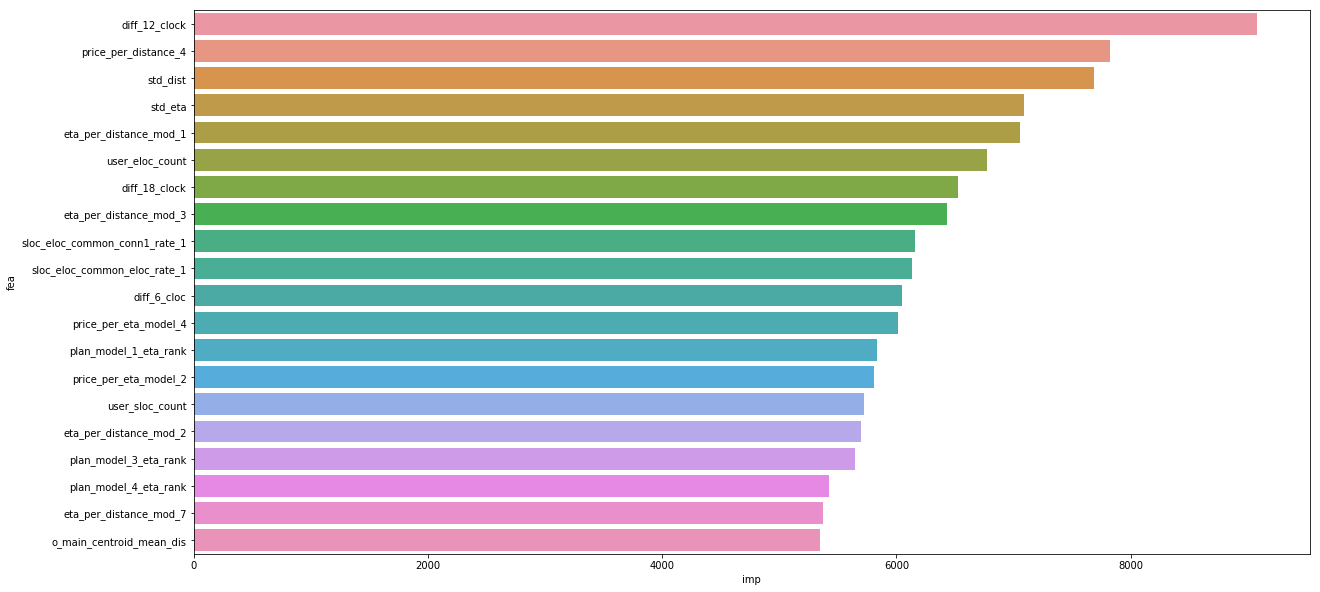

In [27]:
#特征重要性分析
imp = pd.DataFrame()
imp['fea'] = feature
imp['imp'] = lgb_model.feature_importances_ 
imp = imp.sort_values('imp',ascending = False)
imp
plt.figure(figsize=[20,10])
sns.barplot(x = 'imp', y ='fea',data = imp.head(20))

In [28]:
#预测结果分析
proba = lgb_model.predict_proba(valid_x)
pred = pred_proba(proba)
score=f1_score(valid_y, pred, average='weighted')
print('offline_f1_score:', score)
df_analysis = pd.DataFrame()
df_analysis['sid']   = data[valid_index]['sid']
df_analysis['label'] = valid_y.values
df_analysis['pred']  = pred
df_analysis['label'] = df_analysis['label'].astype(int)

score_df = pd.DataFrame(
    columns=['class_id', 'counts*f1_score', 'f1_score', 'precision', 'recall'])

from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score,recall_score,precision_score
dic_ = df_analysis['label'].value_counts(normalize = True)
def get_weighted_fscore(y_pred, y_true):
    f_score = 0
    for i in range(12):
        yt = y_true == i
        yp = y_pred == i
        f_score += dic_[i] * f1_score(y_true=yt, y_pred= yp)
        score_df.loc[i] = i,dic_[i],f1_score(y_true=yt, y_pred= yp), precision_score(y_true=yt, y_pred= yp),recall_score(y_true=yt, y_pred= yp)
    print('f_score:', f_score)
    return score_df
score_df = get_weighted_fscore(y_true =df_analysis['label'] , y_pred = df_analysis['pred'])
print(score_df)

offline_f1_score: 0.7016707936788296
f_score: 0.03947463997246241
    class_id  counts*f1_score  f1_score  precision    recall
0        0.0         0.091511  0.003021   0.058824  0.001550
1        1.0         0.112453  0.026095   0.105546  0.014888
2        2.0         0.273002  0.068012   0.259566  0.039133
3        3.0         0.045103  0.009795   0.058219  0.005348
4        4.0         0.021934  0.004728   0.027397  0.002587
5        5.0         0.096747  0.031202   0.115493  0.018038
6        6.0         0.021949  0.003413   0.014218  0.001939
7        7.0         0.149625  0.044036   0.173290  0.025223
8        8.0         0.004639  0.000000   0.000000  0.000000
9        9.0         0.138005  0.051850   0.157128  0.031048
10      10.0         0.026106  0.006548   0.023490  0.003804
11      11.0         0.018927  0.007486   0.022305  0.004498


In [46]:
#模型训练&提交
all_train_x              = data[data.req_time < '2018-12-01'][feature].reset_index(drop=True)
all_train_y              = data[data.req_time < '2018-12-01'].click_mode.reset_index(drop=True)
print(lgb_model.best_iteration_)
lgb_model.n_estimators   = lgb_model.best_iteration_
lgb_model.fit(all_train_x, all_train_y)
print('fit over')
result                   = pd.DataFrame()
result['sid']            = data[test_index]['sid']
result.reset_index(inplace=True)
result.drop(['index'],axis=1,inplace=True)
result_proba = lgb_model.predict_proba(test_x)
a  = pd.DataFrame(pred_proba(result_proba))
result= pd.concat([result,a],axis=1)
result=result.rename(columns={0:'recommend_mode'})
print(len(result))
print(result['recommend_mode'].value_counts())
filename="shanghai_{:%Y-%m-%d_%H_%M}_sub.csv".format(datetime.now())
result[['sid', 'recommend_mode']].to_csv(filename, index=False)

953
fit over
85933
2     27008
7     16212
1     11366
9     10850
5      9606
10     2450
3      2302
0      1592
11     1572
4      1236
6      1146
8       593
Name: recommend_mode, dtype: int64


In [50]:
data['second_mode']

0          3.0
1          7.0
2         -1.0
3          4.0
4          6.0
5          4.0
6          3.0
7          3.0
8          3.0
9          3.0
10         6.0
11         3.0
12         3.0
13         6.0
14         3.0
15         4.0
16         3.0
17         6.0
18         3.0
19         3.0
20         3.0
21         6.0
22         3.0
23         3.0
24         3.0
25         3.0
26         3.0
27         3.0
28         3.0
29         3.0
          ... 
585903     6.0
585904     3.0
585905     3.0
585906    -1.0
585907     9.0
585908     6.0
585909     3.0
585910     3.0
585911     6.0
585912     3.0
585913     3.0
585914     3.0
585915     6.0
585916     3.0
585917    10.0
585918     3.0
585919     3.0
585920     3.0
585921     3.0
585922     3.0
585923     3.0
585924     3.0
585925     3.0
585926     3.0
585927     6.0
585928     6.0
585929     3.0
585930     3.0
585931     6.0
585932     3.0
Name: second_mode, Length: 585933, dtype: float64

In [19]:
data.columns.values

array(['click_mode', 'click_time', 'd', 'o', 'pid', 'plan_time', 'plans',
       'req_time', 'sid', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7',
       'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17',
       'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26',
       'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35',
       'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44',
       'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53',
       'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62',
       'p63', 'p64', 'p65', 'o_lng', 'o_lat', 'd_lng', 'd_lat',
       'od_manhattan_distance', 'od_manhattan_distance_detail',
       'o_main_centroid_mean_dis', 'd_main_centroid_mean_dis',
       'o_main_centroid_mode_dis', 'd_main_centroid_mode_dis',
       "('o_cluster', 'd_cluster')", 'o_cluster', 'd_cluster',
       'manhattan', 'euclidean', 'delta_longitude', 'delta_latitude',
       'pickup_x', 'pickup_y', 'pickup_z

In [34]:
df = pd.DataFrame({'k1': list('aabba'), 'k2': ['one', 'two', 'one', 'two', 'one'], 'value1': np.random.randn(5), 'value2': np.random.randn(5)})
df

,k1,k2,value1,value2
0,a,one,-0.503755,0.170302
1,a,two,-0.405814,0.103904
2,b,one,-0.736797,1.446600
3,b,two,-0.054750,0.707929
4,a,one,0.759425,-0.749239


In [39]:
df.groupby(['k1','k2']).agg('count').reset_index()


#feat_stat.groupby(['click_mode', feat]).agg('sum').reset_index()

,k1,k2,value1,value2
0,a,one,2,2
1,a,two,1,1
2,b,one,1,1
3,b,two,1,1


In [20]:
data['click_mode'].value_counts()

2.0     129755
7.0      77909
9.0      63084
1.0      57501
0.0      50396
5.0      47459
3.0      25008
10.0     14622
4.0      11486
6.0      11346
11.0      9445
8.0       1989
Name: click_mode, dtype: int64

# 专门调阈值顺序，验证下猜想

In [30]:
proba = lgb_model.predict_proba(valid_x)
the_before_score=0

In [193]:
#proba = lgb_model.predict_proba(valid_x)
def pred_proba(proba):
    res = []
#    pred_proba.tolist()
    for i, row in enumerate(proba):
        row1=list(row)
        
        

        if row[0] >= 0.3892:
            row1[0] = 1
        if row1[1] >= 0.4562:
            row1[1] = 1
        if row1[2] >= 0.4872:
            row1[2] = 1
        if row[3] >= 0.2043:
            row1[3] = 1
        if row[4] >= 0.1544:
            row1[4] = 1  
        if row[5] > 0.3196:
            row1[5] = 1
        if row[6] > 0.1325:
            row1[6] = 1
        if row[7] > 0.30940:
            row1[7] = 1     
        if row[8] > 0.1585:
            row1[8] = 1
        if row[9] >  0.2933:
            row1[9] = 1  
        if row[10] > 0.2133:
            row1[10] = 1
            
        if row[11] > 0.2993:
            row1[11] = 1
        res.append(row1)
        

    df = pd.DataFrame(res)
    #print('duide:',df)
    
#     bushi_1_count=0                                     2553个  不止1个判断结果的。
#     for index,row in df.iterrows():
#         if 1.0 in list(row):
#             bushi_count=list(row).count(1)
#             if bushi_count>1:
#                 bushi_1_count=bushi_1_count+1
            
#     print(bushi_1_count)
    pred=[]
    for ind,row in df.iterrows():
        row=list(row)
        if 1.0 in list(row):

            if row[10]==1:
                pred.append(10)
            elif row[4]==1:
                pred.append(4)
            else:
                pred.append(list(row).index(max(row)))
        else:
            pred.append(row.index(max(row)))
                
    #pred = df.idxmax(axis = 1)
    return pred


'''
            if row[4]==1:                                   0.7001218
                pred.append(4)
            else:
                pred.append(list(row).index(max(row)))       
                
                                                            0.7008423431755854
                                                            
                                                            
                    if row[10]==1:                         0.7008922
                pred.append(10)
            elif row[4]==1:
                pred.append(4)
            else:
                pred.append(list(row).index(max(row)))
        else:
            pred.append(row.index(max(row)))
'''

'\n            if row[4]==1:                                   0.7001218\n                pred.append(4)\n            else:\n                pred.append(list(row).index(max(row)))       \n                \n                                                            0.7008423431755854\n                                                            \n                                                            \n                    if row[10]==1:                         0.7008922\n                pred.append(10)\n            elif row[4]==1:\n                pred.append(4)\n            else:\n                pred.append(list(row).index(max(row)))\n        else:\n            pred.append(row.index(max(row)))\n'

In [194]:
#预测结果分析
import gc
gc.collect()

the_before_score=proba
#print('beefore_f1_score:', score)
print(proba.shape)
pred = pred_proba(proba)
print(len(pred))
score=f1_score(valid_y, pred, average='weighted')
print('offline_f1_score:', score)
df_analysis = pd.DataFrame()
df_analysis['sid']   = data[valid_index]['sid']
df_analysis['label'] = valid_y.values
df_analysis['pred']  = pred
df_analysis['label'] = df_analysis['label'].astype(int)

score_df = pd.DataFrame(
    columns=['class_id', 'counts*f1_score', 'f1_score', 'precision', 'recall'])

from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score,recall_score,precision_score
dic_ = df_analysis['label'].value_counts(normalize = True)
def get_weighted_fscore(y_pred, y_true):
    f_score = 0
    for i in range(12):
        yt = y_true == i
        yp = y_pred == i
        f_score += dic_[i] * f1_score(y_true=yt, y_pred= yp)
        score_df.loc[i] = i,dic_[i],f1_score(y_true=yt, y_pred= yp), precision_score(y_true=yt, y_pred= yp),recall_score(y_true=yt, y_pred= yp)
    print('f_score:', f_score)
    return score_df
score_df = get_weighted_fscore(y_true =df_analysis['label'] , y_pred = df_analysis['pred'])
print(score_df)

(70483, 12)
70483
offline_f1_score: 0.700858822208969
f_score: 0.700858822208969
    class_id  counts*f1_score  f1_score  precision    recall
0        0.0         0.091511  0.311117   0.969968  0.185271
1        1.0         0.112453  0.683496   0.649869  0.720792
2        2.0         0.273002  0.888110   0.868964  0.908118
3        3.0         0.045103  0.174432   0.322581  0.119534
4        4.0         0.021934  0.095563   0.194059  0.063389
5        5.0         0.096747  0.851076   0.800828  0.908051
6        6.0         0.021949  0.317119   0.310068  0.324499
7        7.0         0.149625  0.768857   0.744384  0.794993
8        8.0         0.004639  0.391608   0.360825  0.428135
9        9.0         0.138005  0.796108   0.689282  0.942120
10      10.0         0.026106  0.545498   0.484593  0.623913
11      11.0         0.018927  0.678657   0.565435  0.848576


In [33]:
proba = lgb_model.predict_proba(valid_x)
the_before_score=0

In [188]:
proba

array([[0.05334251, 0.12277022, 0.77210874, ..., 0.00119913, 0.00119991,
        0.0012001 ],
       [0.04222737, 0.04013253, 0.0011855 , ..., 0.77712079, 0.00118795,
        0.00118813],
       [0.03488968, 0.0010436 , 0.00103881, ..., 0.00104028, 0.11758813,
        0.00104111],
       ...,
       [0.09658431, 0.46233965, 0.00160161, ..., 0.00160387, 0.37776901,
        0.00160516],
       [0.10306681, 0.00162319, 0.00161573, ..., 0.59992037, 0.09745423,
        0.00161931],
       [0.04329116, 0.0354712 , 0.00097352, ..., 0.0009749 , 0.00097554,
        0.00097568]])

In [197]:
for kk in range(0,12):
    print('当前索引坐标:',kk)
    #proba = lgb_model.predict_proba(valid_x)
    if kk  in [10,4,3,11,9,0,1,6,2,7]:
            continue
    def pred_proba(proba):
        res = []
        #print(proba)
    #    pred_proba.tolist()
        for i, row in enumerate(proba):
            row1=list(row)


            if row[0] >= 0.2192:
                row1[0] = 1
            if row1[1] >= 0.4462:
                row1[1] = 1
            if row1[2] >= 0.3472:
                row1[2] = 1
            if row[3] >= 0.2043:
                row1[3] = 1
            if row[4] >= 0.1524:
                row1[4] = 1  
            if row[5] > 0.3295:
                row1[5] = 1
            if row[6] > 0.1334:
                row1[6] = 1
            if row[7] > 0.35350:
                row1[7] = 1    
            if row[8] > 0.1642:
                row1[8] = 1
            if row[9] >  0.3071:
                row1[9] = 1  
            if row[10] > 0.2530:
                row1[10] = 1
                
            if row[11] > 0.3013:
                row1[11] = 1
            res.append(row1)


        df = pd.DataFrame(res)
        #print('duide:',df)
    #     bushi_1_count=0                                 #    4961  个  不止1个判断结果的。
    #     for index,row in df.iterrows():
    #         if 1.0 in list(row):
    #             bushi_count=list(row).count(1)
    #             if bushi_count>1:
    #                 bushi_1_count=bushi_1_count+1

    #     print(bushi_1_count)
        pred=[]
        
        
        for ind,row in df.iterrows():
            row=list(row)
            if 1.0 in list(row):

                if row[10]==1:
                    pred.append(10)
                elif row[4]==1:
                    pred.append(4)
                elif row[3]==1:
                    pred.append(3)
                elif row[11]==1:
                    pred.append(11)
                elif row[9]==1:
                    pred.append(9)
                elif row[0]==1:
                    pred.append(0)
                elif row[1]==1:
                    pred.append(1)
                elif row[6]==1:
                    pred.append(6)
                elif row[2]==1:
                    pred.append(2)
                elif row[7]==1:
                    pred.append(7)
                elif row[5]==1:
                    pred.append(5)
                elif row[8]==1:
                    pred.append(8)
#                 elif row[3]==1:
#                     pred.append(3)   
#                 elif row[10]==1:
#                     pred.append(10)  
#                 elif row[11]==1:
#                     pred.append(11) 
#                 elif row[0]==1:
#                     pred.append(0)
#                 elif row[kk]==1:
#                     pred.append(kk)
                else:
                    pred.append(list(row).index(max(row)))
            else:
                pred.append(row.index(max(row)))

        #pred = df.idxmax(axis = 1)
        #print(pred)
        return pred
    
    
    
    #预测结果分析
    import gc
    gc.collect()

    the_before_score=proba
    #print('beefore_f1_score:', score)
    print(proba.shape)
    pred = pred_proba(proba)
    print(len(pred))
    score=f1_score(valid_y, pred, average='weighted')
    print('offline_f1_score:', score)
    df_analysis = pd.DataFrame()
    df_analysis['sid']   = data[valid_index]['sid']
    df_analysis['label'] = valid_y.values
    df_analysis['pred']  = pred
    df_analysis['label'] = df_analysis['label'].astype(int)

    score_df = pd.DataFrame(
        columns=['class_id', 'counts*f1_score', 'f1_score', 'precision', 'recall'])

    from sklearn.metrics import accuracy_score
    from sklearn.metrics import accuracy_score,recall_score,precision_score
    dic_ = df_analysis['label'].value_counts(normalize = True)
    def get_weighted_fscore(y_pred, y_true):
        f_score = 0
        for i in range(12):
            yt = y_true == i
            yp = y_pred == i
            f_score += dic_[i] * f1_score(y_true=yt, y_pred= yp)
            score_df.loc[i] = i,dic_[i],f1_score(y_true=yt, y_pred= yp), precision_score(y_true=yt, y_pred= yp),recall_score(y_true=yt, y_pred= yp)
        print('f_score:', f_score)
        return score_df
    score_df = get_weighted_fscore(y_true =df_analysis['label'] , y_pred = df_analysis['pred'])
    print(score_df) 

当前索引坐标: 0
当前索引坐标: 1
当前索引坐标: 2
当前索引坐标: 3
当前索引坐标: 4
当前索引坐标: 5
(70483, 12)
70483
offline_f1_score: 0.7029383640031619
f_score: 0.702938364003162
    class_id  counts*f1_score  f1_score  precision    recall
0        0.0         0.091511  0.330453   0.669347  0.219380
1        1.0         0.112453  0.676652   0.661485  0.692531
2        2.0         0.273002  0.888116   0.868169  0.909001
3        3.0         0.045103  0.182104   0.319149  0.127399
4        4.0         0.021934  0.100000   0.194757  0.067270
5        5.0         0.096747  0.847470   0.817983  0.879161
6        6.0         0.021949  0.331981   0.320869  0.343891
7        7.0         0.149625  0.771068   0.750314  0.793002
8        8.0         0.004639  0.387097   0.388889  0.385321
9        9.0         0.138005  0.797056   0.688402  0.946438
10      10.0         0.026106  0.550037   0.500223  0.610870
11      11.0         0.018927  0.683837   0.565068  0.865817
当前索引坐标: 6
当前索引坐标: 7
当前索引坐标: 8
(70483, 12)
70483
offline_f1_score:

# 提交结果

In [203]:
def pred_proba(proba):
    res = []
    print(proba)
#    pred_proba.tolist()
    print(proba)
    for i, row in enumerate(proba):
        row1=list(row)
 

        if row[0] >= 0.2192:
            row1[0] = 1
        if row1[1] >= 0.4462:
            row1[1] = 1
        if row1[2] >= 0.3472:
            row1[2] = 1
        if row[3] >= 0.2043:
            row1[3] = 1
        if row[4] >= 0.1524:
            row1[4] = 1  
        if row[5] > 0.3295:
            row1[5] = 1
        if row[6] > 0.1334:
            row1[6] = 1
        if row[7] > 0.35350:
            row1[7] = 1    
        if row[8] > 0.1642:
            row1[8] = 1
        if row[9] >  0.3071:
            row1[9] = 1  
        if row[10] > 0.2530:
            row1[10] = 1

        if row[11] > 0.3013:
            row1[11] = 1
        res.append(row1)


    df = pd.DataFrame(res)
    #print('duide:',df)
#     bushi_1_count=0                                 #    4961  个  不止1个判断结果的。
#     for index,row in df.iterrows():
#         if 1.0 in list(row):
#             bushi_count=list(row).count(1)
#             if bushi_count>1:
#                 bushi_1_count=bushi_1_count+1

#     print(bushi_1_count)
    pred=[]


    for ind,row in df.iterrows():
        row=list(row)
        if 1.0 in list(row):

            if row[10]==1:
                pred.append(10)
            elif row[4]==1:
                pred.append(4)
            elif row[3]==1:
                pred.append(3)
            elif row[11]==1:
                pred.append(11)
            elif row[9]==1:
                pred.append(9)
            elif row[0]==1:
                pred.append(0)
            elif row[1]==1:
                pred.append(1)
            elif row[6]==1:
                pred.append(6)
            elif row[2]==1:
                pred.append(2)
            elif row[7]==1:
                pred.append(7)
            elif row[5]==1:
                pred.append(5)
            elif row[8]==1:
                pred.append(8)
#                 elif row[3]==1:
#                     pred.append(3)   
#                 elif row[10]==1:
#                     pred.append(10)  
#                 elif row[11]==1:
#                     pred.append(11) 
#                 elif row[0]==1:
#                     pred.append(0)
#                 elif row[kk]==1:
#                     pred.append(kk)
            else:
                pred.append(list(row).index(max(row)))
        else:
            pred.append(row.index(max(row)))

    #pred = df.idxmax(axis = 1)
    #print(pred)
    return pred
    

In [204]:
pred_proba(result_proba)
#模型训练&提交
all_train_x              = data[data.req_time < '2018-12-01'][feature].reset_index(drop=True)
all_train_y              = data[data.req_time < '2018-12-01'].click_mode.reset_index(drop=True)
print(lgb_model.best_iteration_)

lgb_model.n_estimators   = lgb_model.best_iteration_
lgb_model.fit(all_train_x, all_train_y)
print('fit over')
result                   = pd.DataFrame()
result['sid']            = data[test_index]['sid']
result.reset_index(inplace=True)
result.drop(['index'],axis=1,inplace=True)
result_proba = lgb_model.predict_proba(test_x)
a  = pd.DataFrame(pred_proba(result_proba))
result= pd.concat([result,a],axis=1)
result=result.rename(columns={0:'recommend_mode'})
print(len(result))
print(result['recommend_mode'].value_counts())
filename="beijing_{:%Y-%m-%d_%H_%M}_sub.csv".format(datetime.now())
result[['sid', 'recommend_mosde']].to_csv(filename, index=False)

[[0.12148125 0.04380213 0.54533158 ... 0.00165231 0.00165261 0.00165319]
 [0.17330713 0.57050462 0.00161109 ... 0.00161363 0.00161391 0.00161448]
 [0.02978013 0.0010353  0.00103063 ... 0.00103225 0.07667721 0.0010328 ]
 ...
 [0.07390007 0.0362642  0.15070135 ... 0.66930109 0.00147075 0.00147126]
 [0.16667068 0.0012145  0.00120903 ... 0.00121093 0.00121114 0.00121157]
 [0.0409136  0.00105021 0.00104547 ... 0.00104712 0.06820018 0.00104767]]
[[0.12148125 0.04380213 0.54533158 ... 0.00165231 0.00165261 0.00165319]
 [0.17330713 0.57050462 0.00161109 ... 0.00161363 0.00161391 0.00161448]
 [0.02978013 0.0010353  0.00103063 ... 0.00103225 0.07667721 0.0010328 ]
 ...
 [0.07390007 0.0362642  0.15070135 ... 0.66930109 0.00147075 0.00147126]
 [0.16667068 0.0012145  0.00120903 ... 0.00121093 0.00121114 0.00121157]
 [0.0409136  0.00105021 0.00104547 ... 0.00104712 0.06820018 0.00104767]]


KeyboardInterrupt: 